#Import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Assuming your CSV files are in the 'Folder' folder in your Google Drive (change the path if needed)
csv_files = [f for f in os.listdir('Folder') if f.endswith('.csv')]
for file in csv_files:
    print(file)



df_2_apts_key_cols.csv
df_2_apts.csv
df_2_apts_regression.csv
df_2_apts_added_columns.csv
df_2_apts_same_origin.csv
df_2_apts_same_destination.csv
df_2_apts_different_origin_destination.csv
df_2_apts_same_destination_sorted.csv
df_2_apts_same_origin_sorted.csv
df_2_apts_same_destination_sorted_smaller_share.csv
df_2_apts_same_destination_sorted_bigger_share.csv
df_2_apts_same_origin_sorted_bigger_share.csv
df_2_apts_same_origin_sorted_smaller_share.csv


In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import data

In [ ]:
# Import data

file_path = '/content/drive/MyDrive/ERAU/BA612/adjacent airports/JW_output/'

df_2_apts_same_origin = pd.read_csv(file_path + "df_2_apts_same_origin.csv")
df_2_apts_same_destination = pd.read_csv(file_path + "df_2_apts_same_destination.csv")
df_2_apts_different_origin_destination = pd.read_csv(file_path + "df_2_apts_different_origin_destination.csv")
df_2_apts_same_destination_sorted = pd.read_csv(file_path + "df_2_apts_same_destination_sorted.csv")
df_2_apts_same_origin_sorted = pd.read_csv(file_path + "df_2_apts_same_origin_sorted.csv")
df_2_apts_same_destination_sorted_smaller_share = pd.read_csv(file_path + "df_2_apts_same_destination_sorted_smaller_share.csv")
df_2_apts_same_destination_sorted_bigger_share = pd.read_csv(file_path + "df_2_apts_same_destination_sorted_bigger_share.csv")
df_2_apts_same_origin_sorted_bigger_share = pd.read_csv(file_path + "df_2_apts_same_origin_sorted_bigger_share.csv")
df_2_apts_same_origin_sorted_smaller_share = pd.read_csv(file_path + "df_2_apts_same_origin_sorted_smaller_share.csv")


#Prepare regression columns

In [ ]:
def prepare_regression_dataframe(df):
    """
    Cleans and engineers features for airport dataset to prepare for regression.
    Returns a DataFrame ready for regression modeling.
    """

    # Create a copy of the input DataFrame
    df_copy = df.copy()

    # Remove rows where 1_Passengers == 1.0
    df_copy = df_copy[df_copy['1_percentage_Passengers'] != 1.0]
    #print(df_copy.head())
    print(f"Removed {len(df) - len(df_copy)} rows where 1_Passengers == 1.0")

    # Ensure datetime format
    df_copy['1_Date'] = pd.to_datetime(df_copy['1_Date'])
    df_copy['2_Date'] = pd.to_datetime(df_copy['2_Date'])

    # Month dummies
    df_copy['month'] = df_copy['1_Date'].dt.month_name()
    month_dummies = pd.get_dummies(df_copy['month'], prefix='month').astype(int)
    df_copy = pd.concat([df_copy, month_dummies], axis=1)

    # Dummy: is adjacent airport in origin
    # df_copy['adjacent_is_origin'] = (df_copy['2_Origin_Airport'] != '').astype(int)

    # Feature engineering with epsilon to avoid division by zero
    epsilon = 1e-20
    df_copy['fare_ratio'] = df_copy['1_Avg. Total Fare(USD)'] / (df_copy['2_Avg. Total Fare(USD)'] + epsilon)
    df_copy['depcount_diff'] = df_copy['1_DepCount'] - df_copy['2_DepCount']
    df_copy['capacity_diff'] = df_copy['1_Operating Airline   Capacity'] - df_copy['2_Operating Airline   Capacity']
    df_copy['origin_size_diff'] = df_copy['1_Origin Size'] - df_copy['2_Origin Size']
    df_copy['destination_size_diff'] = df_copy['1_Destination Size'] - df_copy['2_Destination Size']
    #df_copy['origin_size_ratio'] = df_copy['1_Origin Size'] / (df_copy['2_Origin Size'] + epsilon)
    #df_copy['destination_size_ratio'] = df_copy['1_Destination Size'] / (df_copy['2_Destination Size'] + epsilon)
    #df_copy['ppdew_diff'] = df_copy['1_percentage_PPDEW'] - df_copy['2_percentage_PPDEW']

    # Rename distance columns if needed
    df_copy.rename(columns={
        'origin_apt_distance': 'origin_distance',
        'destination_apt_distance': 'destination_distance'
    }, inplace=True)

    # International market dummy
    df_copy['international_market'] = (df_copy['1_Origin Country Name'] != df_copy['1_Destination Country Name']).astype(int)

    # Region dummies
    origin_region_dummies = pd.get_dummies(df_copy['1_Origin Region Name'], prefix='origin_region').astype(int)
    destination_region_dummies = pd.get_dummies(df_copy['1_Destination Region Name'], prefix='destination_region').astype(int)
    df_copy = pd.concat([df_copy, origin_region_dummies, destination_region_dummies], axis=1)

    # Assemble final regression DataFrame
    regression_columns = [
        'origin_distance', 'destination_distance', 'fare_ratio', 'depcount_diff',
        'capacity_diff', 'origin_size_diff', 'destination_size_diff',
        'international_market', #'adjacent_is_origin',
        '1_percentage_Passengers', '1_percentage_PPDEW'
    ]

    month_dummies = df_copy[[col for col in df_copy.columns if col.startswith('month_')]]
    origin_region_dummies = df_copy[[col for col in df_copy.columns if col.startswith('origin_region_')]]
    destination_region_dummies = df_copy[[col for col in df_copy.columns if col.startswith('destination_region_')]]

    df_regression = pd.concat([
        df_copy[regression_columns],
        month_dummies,
        origin_region_dummies,
        destination_region_dummies
    ], axis=1).copy()

    return df_regression, df_copy

##df_2_apts_same_destination_sorted

In [ ]:
df_2_apts_same_destination_sorted_regression, df_2_apts_same_destination_sorted_new = prepare_regression_dataframe(df_2_apts_same_destination_sorted)

Removed 3548 rows where 1_Passengers == 1.0


###df_2_apts_same_destination_sorted_bigger_share

In [ ]:
df_2_apts_same_destination_sorted_bigger_share_regression, df_2_apts_same_destination_sorted_bigger_share_new = prepare_regression_dataframe(df_2_apts_same_destination_sorted_bigger_share)

Removed 3548 rows where 1_Passengers == 1.0


###df_2_apts_same_destination_sorted_smaller_share

In [ ]:
df_2_apts_same_destination_sorted_smaller_share_regression, df_2_apts_same_destination_sorted_smaller_share_new = prepare_regression_dataframe(df_2_apts_same_destination_sorted_smaller_share)

Removed 0 rows where 1_Passengers == 1.0


##df_2_apts_same_origin_sorted

In [ ]:
df_2_apts_same_origin_sorted_regression, df_2_apts_same_origin_sorted_new = prepare_regression_dataframe(df_2_apts_same_origin_sorted)

Removed 3594 rows where 1_Passengers == 1.0


###df_2_apts_same_origin_sorted_bigger_share

In [ ]:
df_2_apts_same_origin_sorted_bigger_share_regression, df_2_apts_same_origin_sorted_bigger_share_new = prepare_regression_dataframe(df_2_apts_same_origin_sorted_bigger_share)

Removed 3594 rows where 1_Passengers == 1.0


###df_2_apts_same_origin_sorted_smaller_share

In [ ]:
df_2_apts_same_origin_sorted_smaller_share_regression, df_2_apts_same_origin_sorted_smaller_share_new = prepare_regression_dataframe(df_2_apts_same_origin_sorted_smaller_share)

Removed 0 rows where 1_Passengers == 1.0


#Regression

##Regression Function

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_ols_regression(
    df_regression,
    target='1_percentage_Passengers',
    drop_columns=None,
    test_size=0.3,
    random_state=42,
    top_n_features=50,
    coef_plot_title="Top 50 Features by Coefficient (Absolute Value)",
    y_plot_title="Predicted vs Actual (Test Set)"
):
    """
    Runs OLS regression using statsmodels and visualizes the top N feature coefficients.

    Parameters:
    - df_regression: pandas DataFrame containing predictors and target variable
    - target: the target column name
    - drop_columns: list of column names to drop from the independent variables
    - test_size: fraction of data to use as test set
    - random_state: for reproducibility in train/test split
    - top_n_features: number of top features to display in bar chart
    - plot_title: title of the coefficient plot
    """

    df_model = df_regression.copy()

    # Drop unwanted columns
    if drop_columns:
        df_model = df_model.drop(columns=drop_columns, errors='ignore')

    # Define independent and dependent variables
    X = df_model.drop(columns=[target])
    X = sm.add_constant(X, has_constant='add')  # Add intercept
    y = df_model[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit model
    model = sm.OLS(y_train, X_train).fit()
    print(model.summary())

    # Predict on test data
    y_pred = model.predict(X_test)

    # === Evaluation ===
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Evaluation on Test Set ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Plot top N coefficients
    coefs = model.params.drop('const', errors='ignore')
    top_coefs = coefs.abs().sort_values(ascending=False).head(top_n_features)

    plt.figure(figsize=(10, 12))
    sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='Blues_r')
    plt.title(coef_plot_title)
    plt.xlabel("Coefficient (Absolute Value)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # === Plot Predicted vs Actual ===
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # y = x line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(y_plot_title)
    plt.tight_layout()
    plt.show()


    return model, X_train, X_test, y_train, y_test, y_pred


##Same Destination

SAME DESTINATION:
                               OLS Regression Results                              
Dep. Variable:     1_percentage_Passengers   R-squared:                       0.327
Model:                                 OLS   Adj. R-squared:                  0.324
Method:                      Least Squares   F-statistic:                     127.7
Date:                     Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                             00:11:34   Log-Likelihood:                 1285.2
No. Observations:                    12686   AIC:                            -2472.
Df Residuals:                        12637   BIC:                            -2107.
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<ipython-input-14-729f3a1a6cea>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='Blues_r')


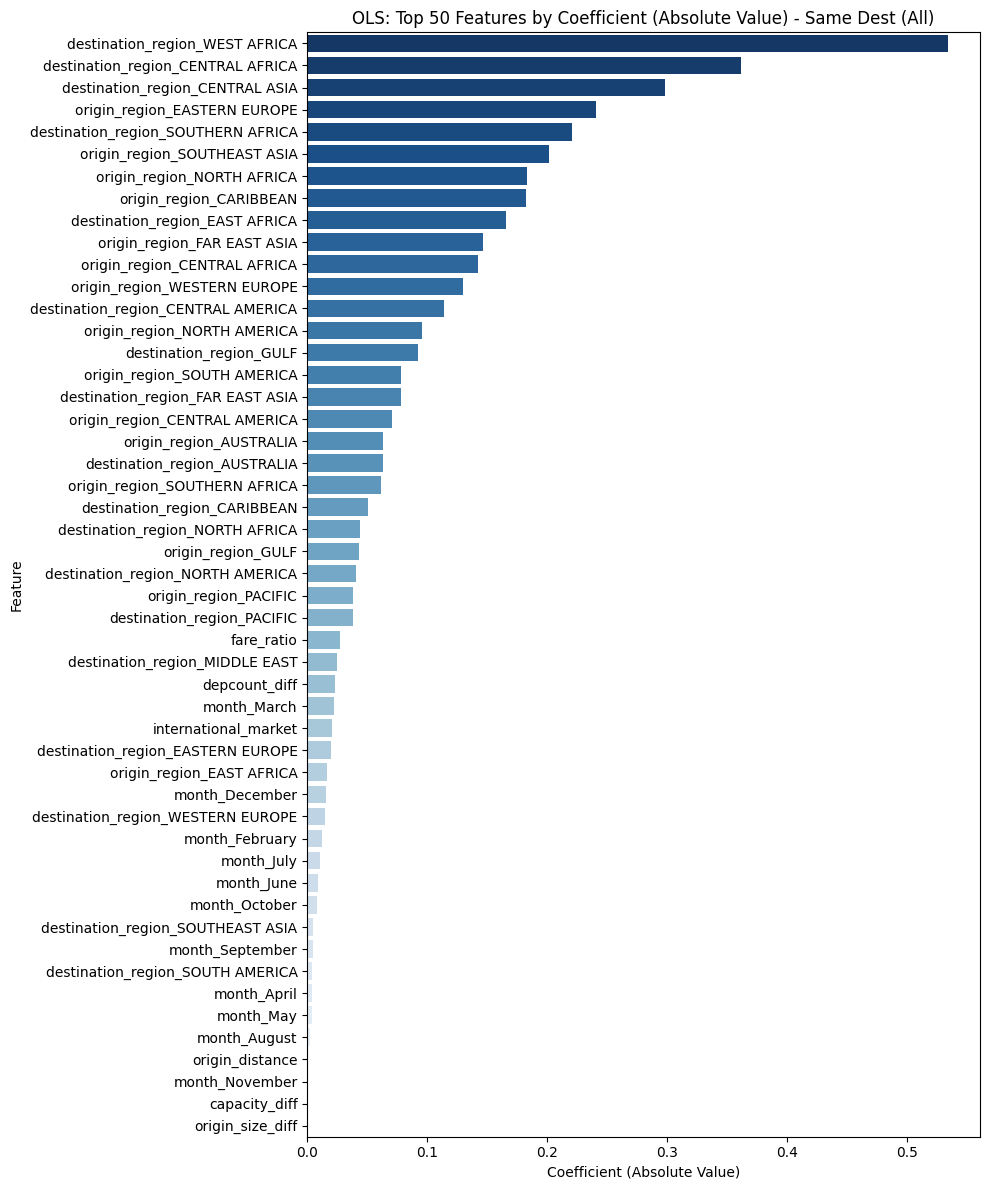

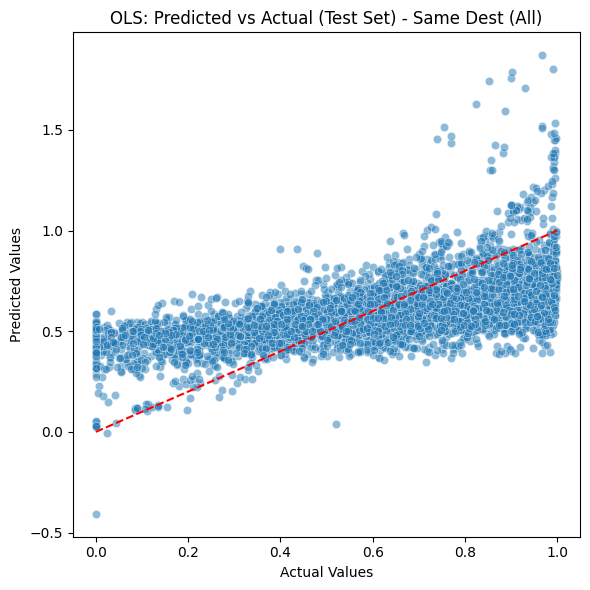

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_ols_1, X_train, X_test, y_train, y_test, y_pred = run_ols_regression(
    df_regression=df_2_apts_same_destination_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="OLS: Top 50 Features by Coefficient (Absolute Value) - Same Dest (All)",
    y_plot_title = "OLS: Predicted vs Actual (Test Set) - Same Dest (All)"
)


In [ ]:
# print the coefficients for model_ols_1
print(model_ols_1.params)

const                                 6.670834e-01
origin_distance                      -4.282770e-04
fare_ratio                           -2.688835e-02
depcount_diff                         2.314765e-02
capacity_diff                         5.332425e-05
origin_size_diff                      6.015923e-07
international_market                  2.056838e-02
month_April                           3.694361e-03
month_August                          2.493825e-03
month_December                        1.570422e-02
month_February                        1.251436e-02
month_July                           -1.073450e-02
month_June                            8.890017e-03
month_March                           2.261592e-02
month_May                            -3.554066e-03
month_November                       -6.385546e-05
month_October                         8.091899e-03
month_September                       4.462769e-03
origin_region_AUSTRALIA              -6.311503e-02
origin_region_CARIBBEAN        

###Bigger share

SAME DESTINATION:
                               OLS Regression Results                              
Dep. Variable:     1_percentage_Passengers   R-squared:                       0.221
Model:                                 OLS   Adj. R-squared:                  0.217
Method:                      Least Squares   F-statistic:                     52.22
Date:                     Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                             00:12:48   Log-Likelihood:                 4294.8
No. Observations:                     8694   AIC:                            -8494.
Df Residuals:                         8646   BIC:                            -8154.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<ipython-input-14-729f3a1a6cea>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='Blues_r')


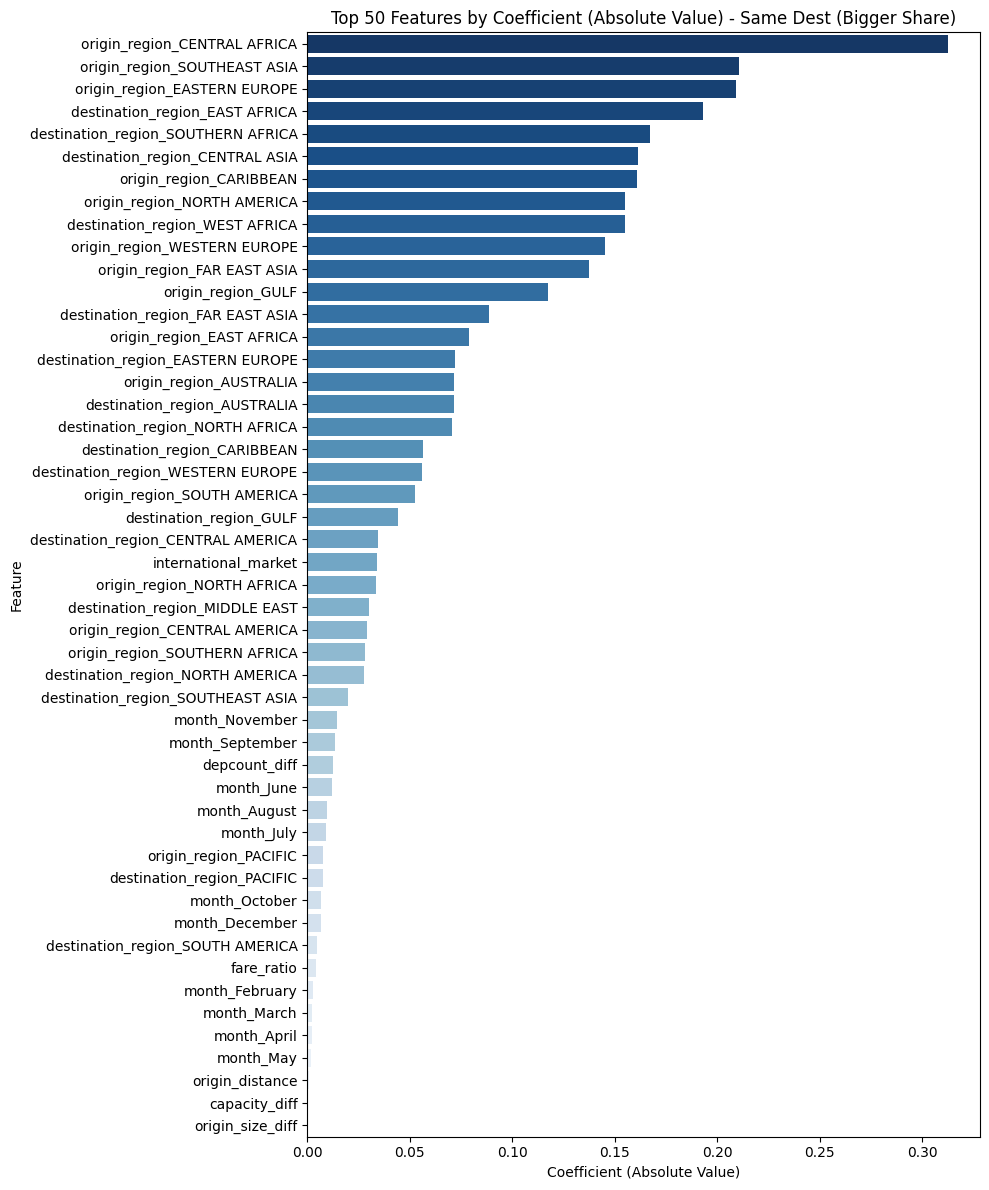

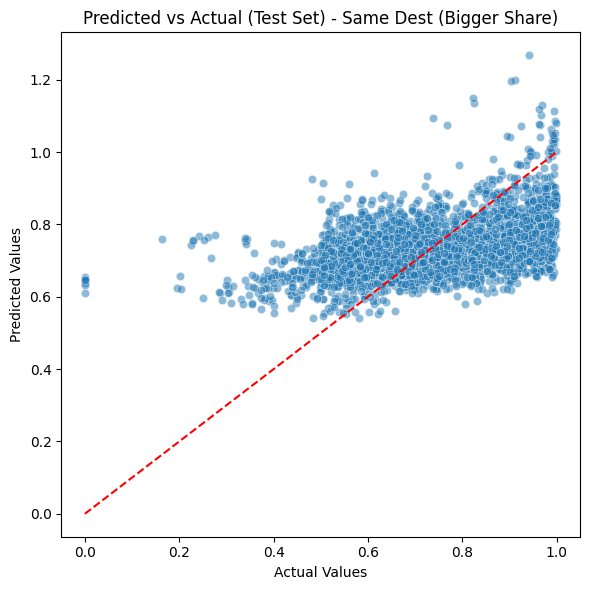

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_ols_2, X_train, X_test, y_train, y_test, y_pred = run_ols_regression(
    df_regression=df_2_apts_same_destination_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Top 50 Features by Coefficient (Absolute Value) - Same Dest (Bigger Share)",
    y_plot_title = "Predicted vs Actual (Test Set) - Same Dest (Bigger Share)"
)


###Smaller share

SAME DESTINATION:
                               OLS Regression Results                              
Dep. Variable:     1_percentage_Passengers   R-squared:                       0.254
Model:                                 OLS   Adj. R-squared:                  0.246
Method:                      Least Squares   F-statistic:                     29.93
Date:                     Fri, 25 Apr 2025   Prob (F-statistic):          1.41e-214
Time:                             00:12:57   Log-Likelihood:                 2488.4
No. Observations:                     3992   AIC:                            -4885.
Df Residuals:                         3946   BIC:                            -4595.
Df Model:                               45                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<ipython-input-14-729f3a1a6cea>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='Blues_r')


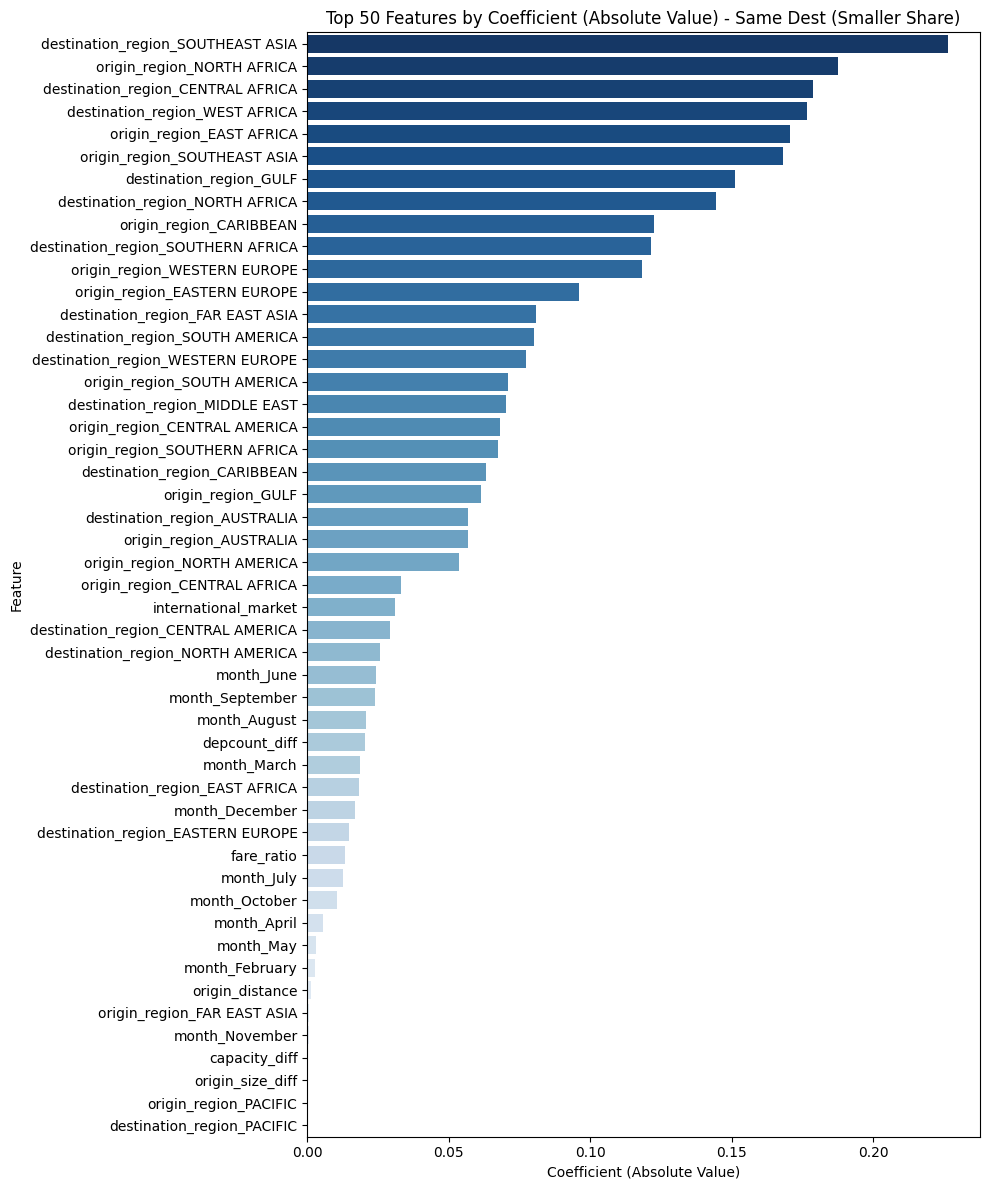

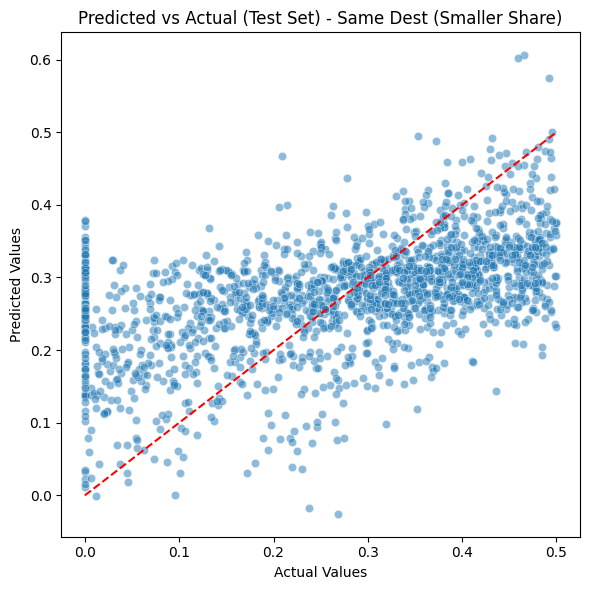

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_ols_3, X_train, X_test, y_train, y_test, y_pred = run_ols_regression(
    df_regression=df_2_apts_same_destination_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Top 50 Features by Coefficient (Absolute Value) - Same Dest (Smaller Share)",
    y_plot_title = "Predicted vs Actual (Test Set) - Same Dest (Smaller Share)"
)


##Same Origin

SAME ORIGIN:
                               OLS Regression Results                              
Dep. Variable:     1_percentage_Passengers   R-squared:                       0.341
Model:                                 OLS   Adj. R-squared:                  0.339
Method:                      Least Squares   F-statistic:                     138.9
Date:                     Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                             00:13:06   Log-Likelihood:                 1372.6
No. Observations:                    12654   AIC:                            -2649.
Df Residuals:                        12606   BIC:                            -2292.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

<ipython-input-14-729f3a1a6cea>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='Blues_r')


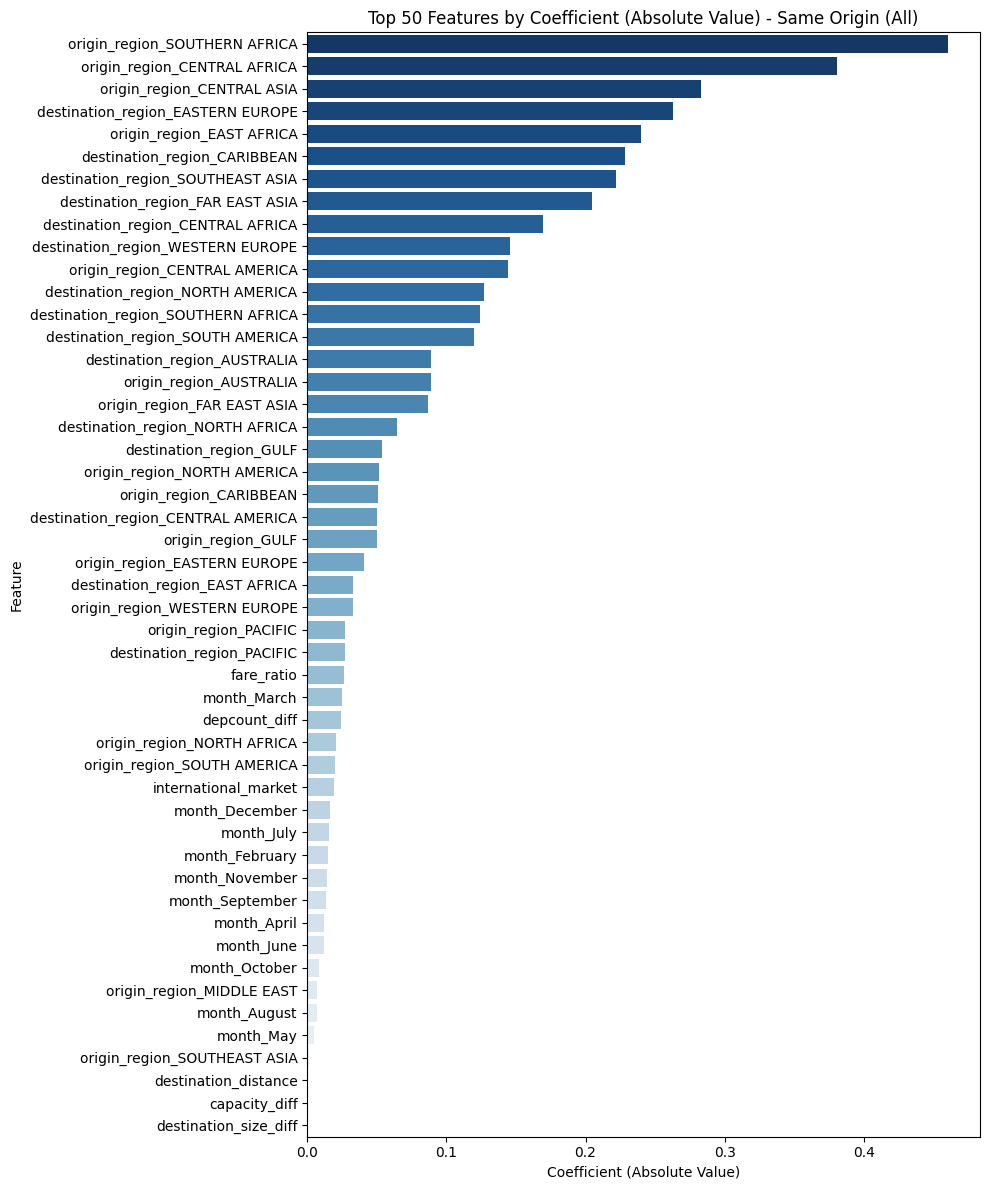

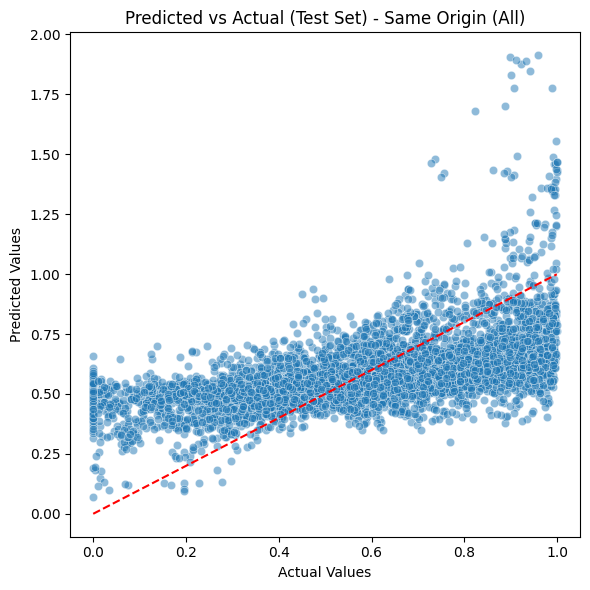

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_ols_4, X_train, X_test, y_train, y_test, y_pred = run_ols_regression(
    df_regression=df_2_apts_same_origin_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Top 50 Features by Coefficient (Absolute Value) - Same Origin (All)",
    y_plot_title = "Predicted vs Actual (Test Set) - Same Origin (All)"
)


###Bigger share

SAME ORIGIN:
                               OLS Regression Results                              
Dep. Variable:     1_percentage_Passengers   R-squared:                       0.230
Model:                                 OLS   Adj. R-squared:                  0.226
Method:                      Least Squares   F-statistic:                     55.88
Date:                     Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                             00:13:21   Log-Likelihood:                 4386.6
No. Observations:                     8650   AIC:                            -8679.
Df Residuals:                         8603   BIC:                            -8347.
Df Model:                               46                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

<ipython-input-14-729f3a1a6cea>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='Blues_r')


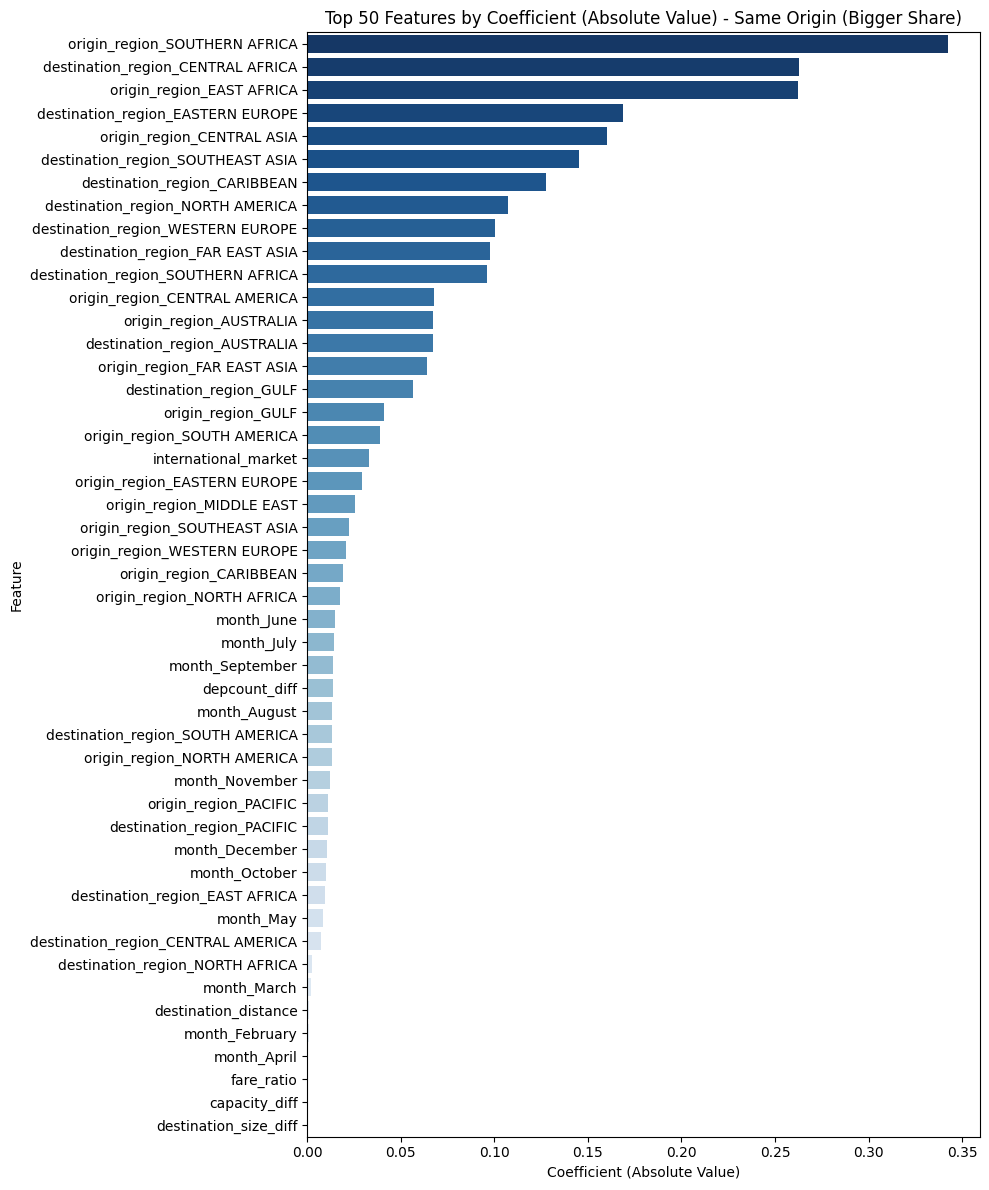

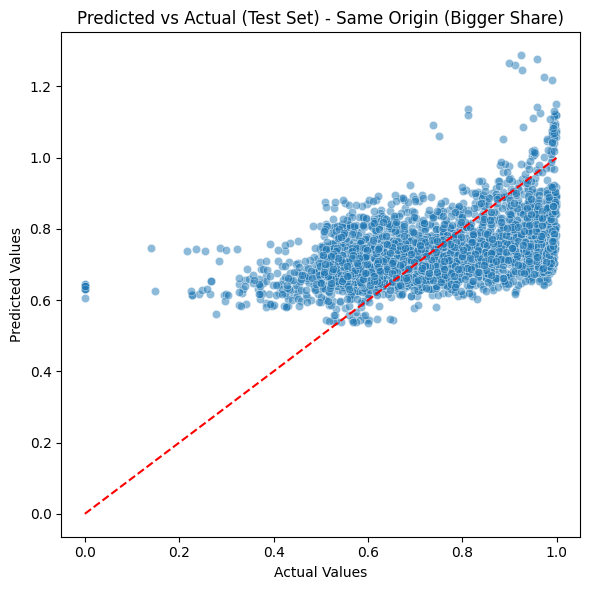

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_ols_5, X_train, X_test, y_train, y_test, y_pred = run_ols_regression(
    df_regression=df_2_apts_same_origin_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Top 50 Features by Coefficient (Absolute Value) - Same Origin (Bigger Share)",
    y_plot_title = "Predicted vs Actual (Test Set) - Same Origin (Bigger Share)"
)


###Smaller share

SAME ORIGIN:
                               OLS Regression Results                              
Dep. Variable:     1_percentage_Passengers   R-squared:                       0.257
Model:                                 OLS   Adj. R-squared:                  0.249
Method:                      Least Squares   F-statistic:                     31.14
Date:                     Fri, 25 Apr 2025   Prob (F-statistic):          4.65e-219
Time:                             00:13:28   Log-Likelihood:                 2555.1
No. Observations:                     4004   AIC:                            -5020.
Df Residuals:                         3959   BIC:                            -4737.
Df Model:                               44                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

<ipython-input-14-729f3a1a6cea>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='Blues_r')


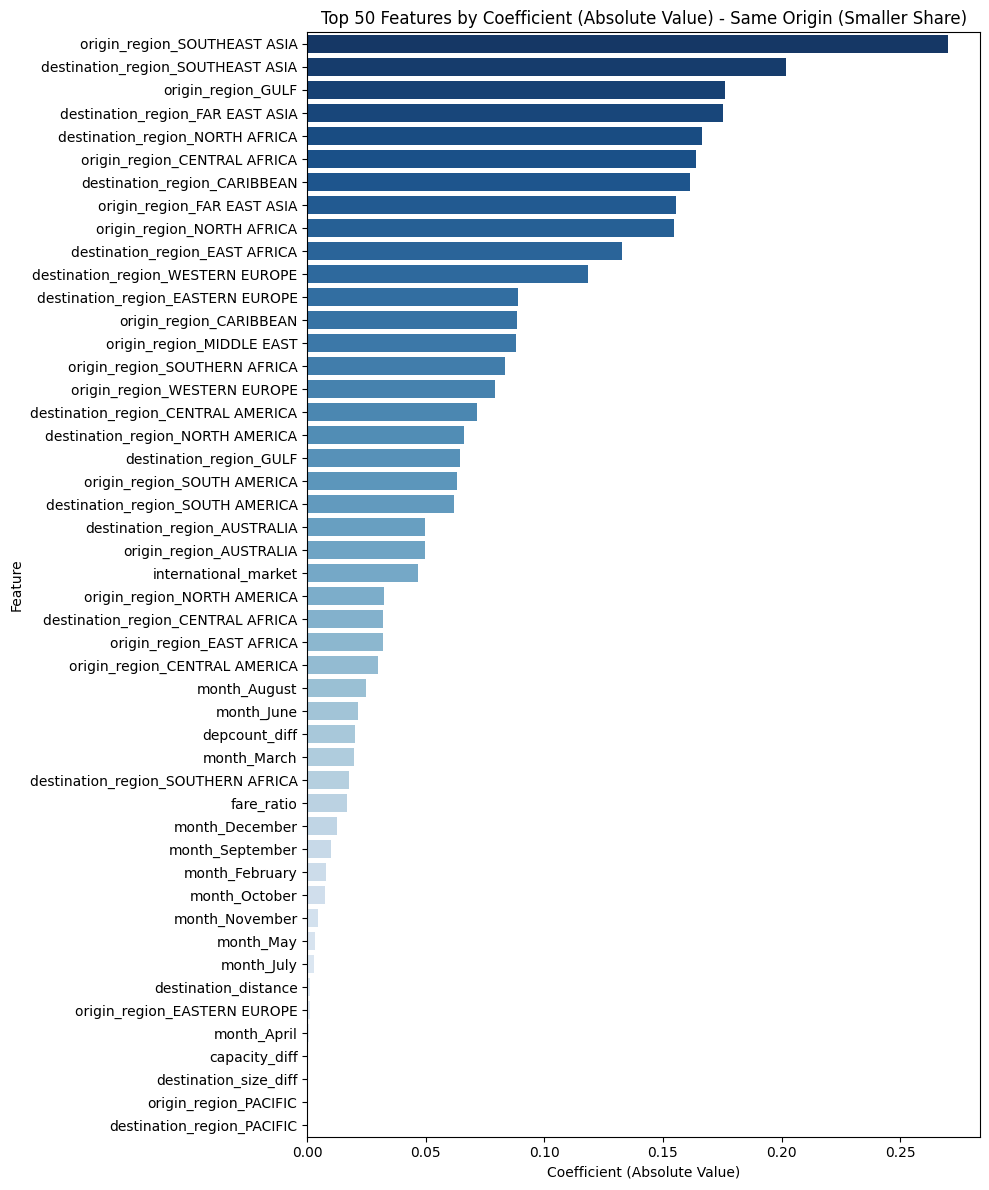

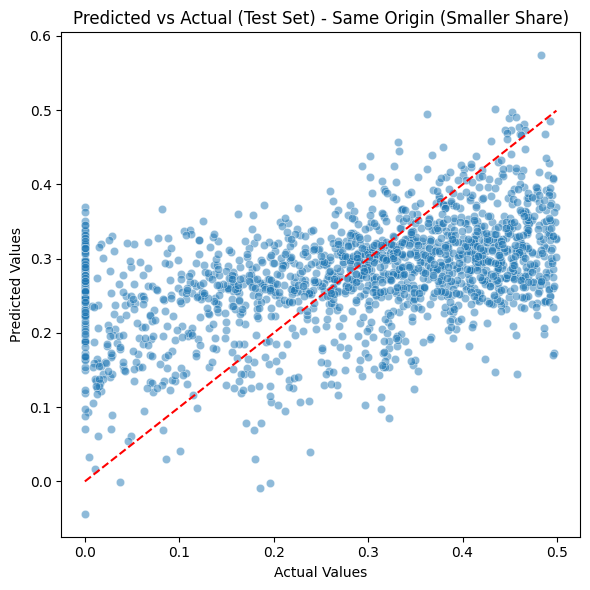

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_ols_6, X_train, X_test, y_train, y_test, y_pred = run_ols_regression(
    df_regression=df_2_apts_same_origin_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Top 50 Features by Coefficient (Absolute Value) - Same Origin (Smaller Share)",
    y_plot_title = "Predicted vs Actual (Test Set) - Same Origin (Smaller Share)"
)


###Summary of OLS

In [ ]:
# create a dataframe combining the params of model_ols_1,2,3,4,5,6

df_ols_params = pd.DataFrame({
    'Scenario 1': model_ols_1.params,
    'Scenario 2': model_ols_2.params,
    'Scenario 3': model_ols_3.params,
    'Scenario 4': model_ols_4.params,
    'Scenario 5': model_ols_5.params,
    'Scenario 6': model_ols_6.params
})

df_ols_params

Scenario 1    Scenario 2    Scenario 3  \
capacity_diff                       5.332425e-05  9.740181e-06  3.050031e-05   
const                               6.670834e-01  7.821983e-01  3.372225e-01   
depcount_diff                       2.314765e-02  1.264195e-02  2.043211e-02   
destination_distance                         NaN           NaN           NaN   
destination_region_AUSTRALIA       -6.311503e-02 -7.146353e-02  5.680170e-02   
destination_region_CARIBBEAN       -5.041142e-02  5.642575e-02  6.326416e-02   
destination_region_CENTRAL AFRICA  -3.619742e-01           NaN -1.788437e-01   
destination_region_CENTRAL AMERICA -1.139093e-01 -3.463423e-02  2.919394e-02   
destination_region_CENTRAL ASIA     2.983258e-01  1.612471e-01           NaN   
destination_region_EAST AFRICA     -1.658321e-01 -1.931219e-01 -1.825278e-02   
destination_region_EASTERN EUROPE  -1.969015e-02  7.197640e-02 -1.483887e-02   
destination_region_FAR EAST ASIA    7.854156e-02  8.842209e-02  8.082403e-02   
destination_region_GULF             9.244861e-02  4.435654e-02  1.511600e-01   
destination_region_MIDDLE EAST      2.443525e-02  2.992456e-02  7.011070e-02   
destination_region_NORTH AFRICA     4.411597e-02  7.036805e-02  1.444793e-01   
destination_region_NORTH AMERICA   -4.023110e-02  2.767561e-02  2.565154e-02   
destination_region_PACIFIC          3.781636e-02 -7.668681e-03  2.269854e-16   
destination_region_SOUTH AMERICA   -3.914715e-03 -4.669023e-03  8.028968e-02   
destination_region_SOUTHEAST ASIA   4.735970e-03  1.965538e-02  2.264574e-01   
destination_region_SOUTHERN AFRICA -2.209137e-01 -1.673371e-01  1.214192e-01   
destination_region_WEST AFRICA     -5.342672e-01 -1.548564e-01 -1.767087e-01   
destination_region_WESTERN EUROPE  -1.451054e-02  5.591802e-02  7.726433e-02   
destination_size_diff                        NaN           NaN           NaN   
fare_ratio                         -2.688835e-02  4.114749e-03 -1.336772e-02   
international_market                2.056838e-02  3.420664e-02 -3.092300e-02   
month_April                         3.694361e-03  2.212684e-03  5.664464e-03   
month_August                        2.493825e-03 -9.727332e-03  2.071749e-02   
month_December                      1.570422e-02 -6.562895e-03  1.670196e-02   
month_February                      1.251436e-02  2.630942e-03 -2.847397e-03   
month_July                         -1.073450e-02 -9.281760e-03  1.256732e-02   
month_June                          8.890017e-03 -1.184439e-02  2.436556e-02   
month_March                         2.261592e-02  2.453107e-03  1.879562e-02   
month_May                          -3.554066e-03  1.693218e-03  2.964042e-03   
month_November                     -6.385546e-05 -1.431647e-02 -4.495844e-04   
month_October                       8.091899e-03 -6.795207e-03  1.068071e-02   
month_September                     4.462769e-03 -1.366990e-02  2.396541e-02   
origin_distance                    -4.282770e-04 -8.390951e-04 -1.237478e-03   
origin_region_AUSTRALIA            -6.311503e-02 -7.146353e-02  5.680170e-02   
origin_region_CARIBBEAN            -1.825905e-01 -1.606419e-01 -1.223865e-01   
origin_region_CENTRAL AFRICA       -1.420654e-01 -3.125914e-01  3.299657e-02   
origin_region_CENTRAL AMERICA       7.053958e-02 -2.909359e-02 -6.811125e-02   
origin_region_CENTRAL ASIA                   NaN           NaN           NaN   
origin_region_EAST AFRICA          -1.625866e-02 -7.890262e-02  1.705514e-01   
origin_region_EASTERN EUROPE       -2.408148e-01 -2.092574e-01 -9.600491e-02   
origin_region_FAR EAST ASIA        -1.465025e-01 -1.374482e-01 -5.058048e-04   
origin_region_GULF                 -4.292610e-02 -1.172224e-01 -6.150924e-02   
origin_region_MIDDLE EAST                    NaN           NaN           NaN   
origin_region_NORTH AFRICA         -1.836313e-01 -3.334171e-02 -1.875884e-01   
origin_region_NORTH AMERICA        -9.527455e-02 -1.552457e-01 -5.379072e-02   
origin_region_PACIFIC               3.

In [ ]:
df_ols_params.to_latex('ols_params.tex')

#Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def run_ridge_regression(
    df_regression,
    target='1_percentage_Passengers',
    drop_columns=None,
    test_size=0.3,
    random_state=42,
    alphas=np.logspace(-3, 3, 100),
    top_n_features=50,
    coef_plot_title="RidgeCV: Top 50 Features by Coefficient (Absolute Value)",
    y_plot_title="RidgeCV: Predicted vs Actual (Test Set)"
):
    df_model = df_regression.copy()
    if drop_columns:
        df_model = df_model.drop(columns=drop_columns, errors='ignore')

    X = df_model.drop(columns=[target])
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = RidgeCV(alphas=alphas, cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- Best Alpha via RidgeCV: {model.alpha_:.4f} ---")
    print("\n--- Evaluation on Test Set ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    })#.sort_values(by="Coefficient", key=lambda x: abs(x), ascending=False)

    print(f"\n--- Top {top_n_features} Coefficients by Absolute Value ---")
    print(coef_df.head(top_n_features).to_string(index=False))

    plt.figure(figsize=(10, 12))
    sns.barplot(x=coef_df.head(top_n_features)['Coefficient'].abs(), y=coef_df.head(top_n_features)['Feature'], palette='Blues_r')
    plt.title(coef_plot_title)
    plt.xlabel("Coefficient (Absolute Value)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(y_plot_title)
    plt.tight_layout()
    plt.show()

    return model, X_train, X_test, y_train, y_test, y_pred, coef_df


##Same Destination

SAME DESTINATION:

--- Best Alpha via RidgeCV: 0.7055 ---

--- Evaluation on Test Set ---
RMSE: 0.2181
R² Score: 0.3284

--- Top 50 Coefficients by Absolute Value ---
                           Feature   Coefficient
                   origin_distance -4.276626e-04
                        fare_ratio -2.681734e-02
                     depcount_diff  2.315371e-02
                     capacity_diff  5.336682e-05
                  origin_size_diff  5.987390e-07
              international_market  2.046714e-02
                       month_April  3.648347e-03
                      month_August  2.414208e-03
                    month_December  1.570070e-02
                    month_February  1.245364e-02
                        month_July -1.081163e-02
                        month_June  8.807196e-03
                       month_March  2.256124e-02
                         month_May -3.562679e-03
                    month_November -1.526043e-04
                     month_October  8.070094e-03


<ipython-input-47-09c1e04a4008>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.head(top_n_features)['Coefficient'].abs(), y=coef_df.head(top_n_features)['Feature'], palette='Blues_r')


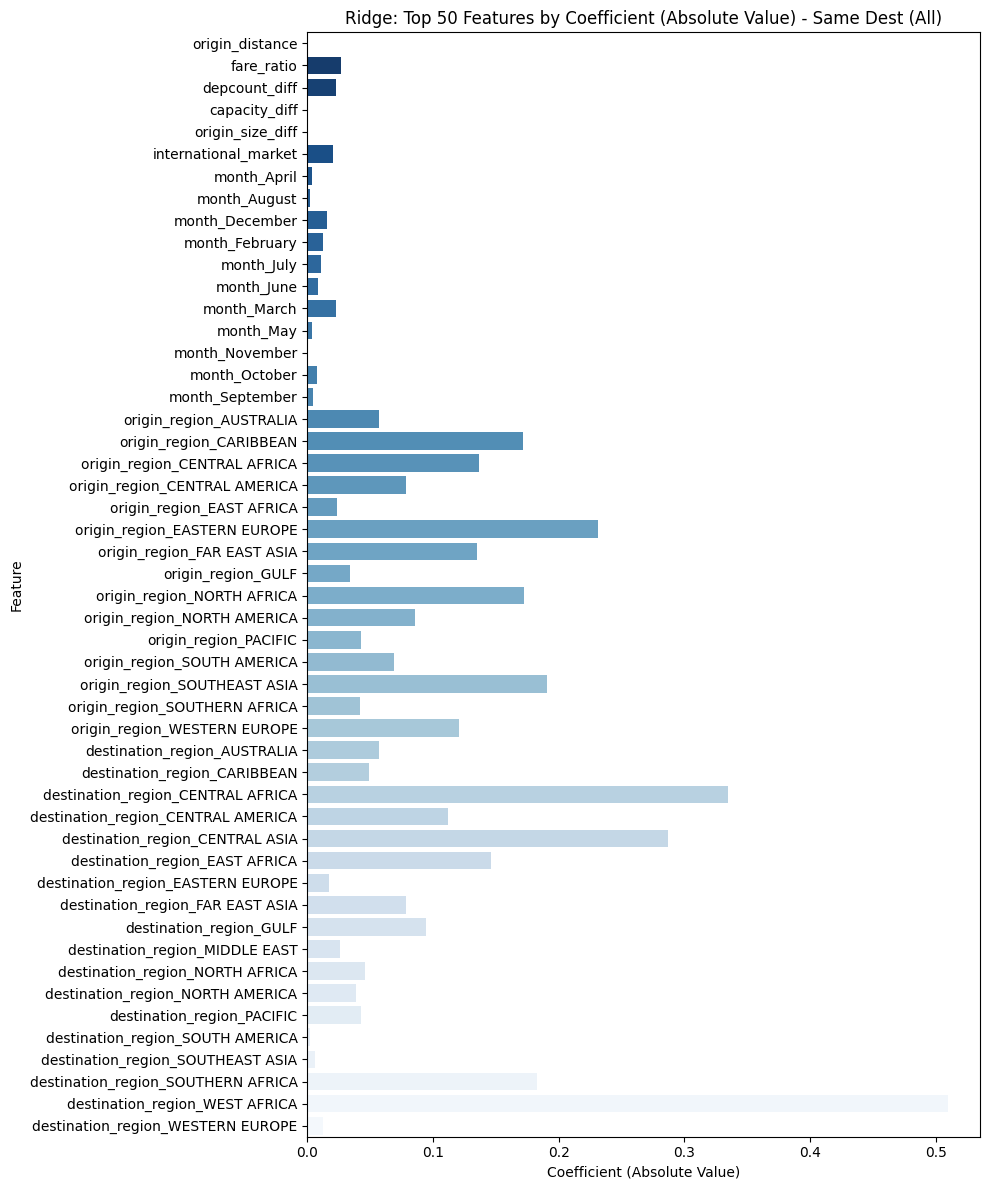

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_ridge_1, X_train, X_test, y_train, y_test, y_pred, coef_ridge_1 = run_ridge_regression(
    df_regression=df_2_apts_same_destination_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Ridge: Top 50 Features by Coefficient (Absolute Value) - Same Dest (All)",
    y_plot_title = "Ridge: Predicted vs Actual (Test Set) - Same Dest (All)"
)


In [ ]:
# print the coefficients of the variables in model_ridge_1
coef_ridge_1

Feature   Coefficient
0                      origin_distance -4.276626e-04
1                           fare_ratio -2.681734e-02
2                        depcount_diff  2.315371e-02
3                        capacity_diff  5.336682e-05
4                     origin_size_diff  5.987390e-07
5                 international_market  2.046714e-02
6                          month_April  3.648347e-03
7                         month_August  2.414208e-03
8                       month_December  1.570070e-02
9                       month_February  1.245364e-02
10                          month_July -1.081163e-02
11                          month_June  8.807196e-03
12                         month_March  2.256124e-02
13                           month_May -3.562679e-03
14                      month_November -1.526043e-04
15                       month_October  8.070094e-03
16                     month_September  4.445936e-03
17             origin_region_AUSTRALIA -5.698491e-02
18             origin_region_CARIBBEAN -1.720003e-01
19        origin_region_CENTRAL AFRICA -1.367922e-01
20       origin_region_CENTRAL AMERICA  7.825580e-02
21           origin_region_EAST AFRICA -2.391338e-02
22        origin_region_EASTERN EUROPE -2.311796e-01
23         origin_region_FAR EAST ASIA -1.352244e-01
24                  origin_region_GULF -3.368053e-02
25          origin_region_NORTH AFRICA -1.727842e-01
26         origin_region_NORTH AMERICA -8.572905e-02
27               origin_region_PACIFIC  4.305080e-02
28         origin_region_SOUTH AMERICA -6.891916e-02
29        origin_region_SOUTHEAST ASIA -1.907773e-01
30       origin_region_SOUTHERN AFRICA  4.170390e-02
31        origin_region_WESTERN EUROPE -1.209786e-01
32        destination_region_AUSTRALIA -5.698491e-02
33        destination_region_CARIBBEAN -4.885730e-02
34   destination_region_CENTRAL AFRICA -3.346923e-01
35  destination_region_CENTRAL AMERICA -1.116076e-01
36     destination_region_CENTRAL ASIA  2.872596e-01
37      destination_region_EAST AFRICA -1.461585e-01
38   destination_region_EASTERN EUROPE -1.757366e-02
39    destination_region_FAR EAST ASIA  7.864224e-02
40             destination_region_GULF  9.453200e-02
41      destination_region_MIDDLE EAST  2.617617e-02
42     destination_region_NORTH AFRICA  4.613961e-02
43    destination_region_NORTH AMERICA -3.860721e-02
44          destination_region_PACIFIC  4.305080e-02
45    destination_region_SOUTH AMERICA -2.343668e-03
46   destination_region_SOUTHEAST ASIA  6.035660e-03
47  destination_region_SOUTHERN AFRICA -1.827513e-01
48      destination_region_WEST AFRICA -5.097333e-01
49   destination_region_WESTERN EUROPE -1.269872e-02

###Bigger share

SAME DESTINATION:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.09306e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



--- Best Alpha via RidgeCV: 0.4642 ---

--- Evaluation on Test Set ---
RMSE: 0.1450
R² Score: 0.2222

--- Top 50 Coefficients by Absolute Value ---
                           Feature   Coefficient
                   origin_distance -8.369206e-04
                        fare_ratio  4.264416e-03
                     depcount_diff  1.265613e-02
                     capacity_diff  9.718364e-06
                  origin_size_diff  4.999848e-07
              international_market  3.415595e-02
                       month_April  2.195726e-03
                      month_August -9.715084e-03
                    month_December -6.581122e-03
                    month_February  2.631154e-03
                        month_July -9.227739e-03
                        month_June -1.186848e-02
                       month_March  2.438780e-03
                         month_May  1.720291e-03
                    month_November -1.438764e-02
                     month_October -6.818292e-03
                  

<ipython-input-47-09c1e04a4008>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.head(top_n_features)['Coefficient'].abs(), y=coef_df.head(top_n_features)['Feature'], palette='Blues_r')


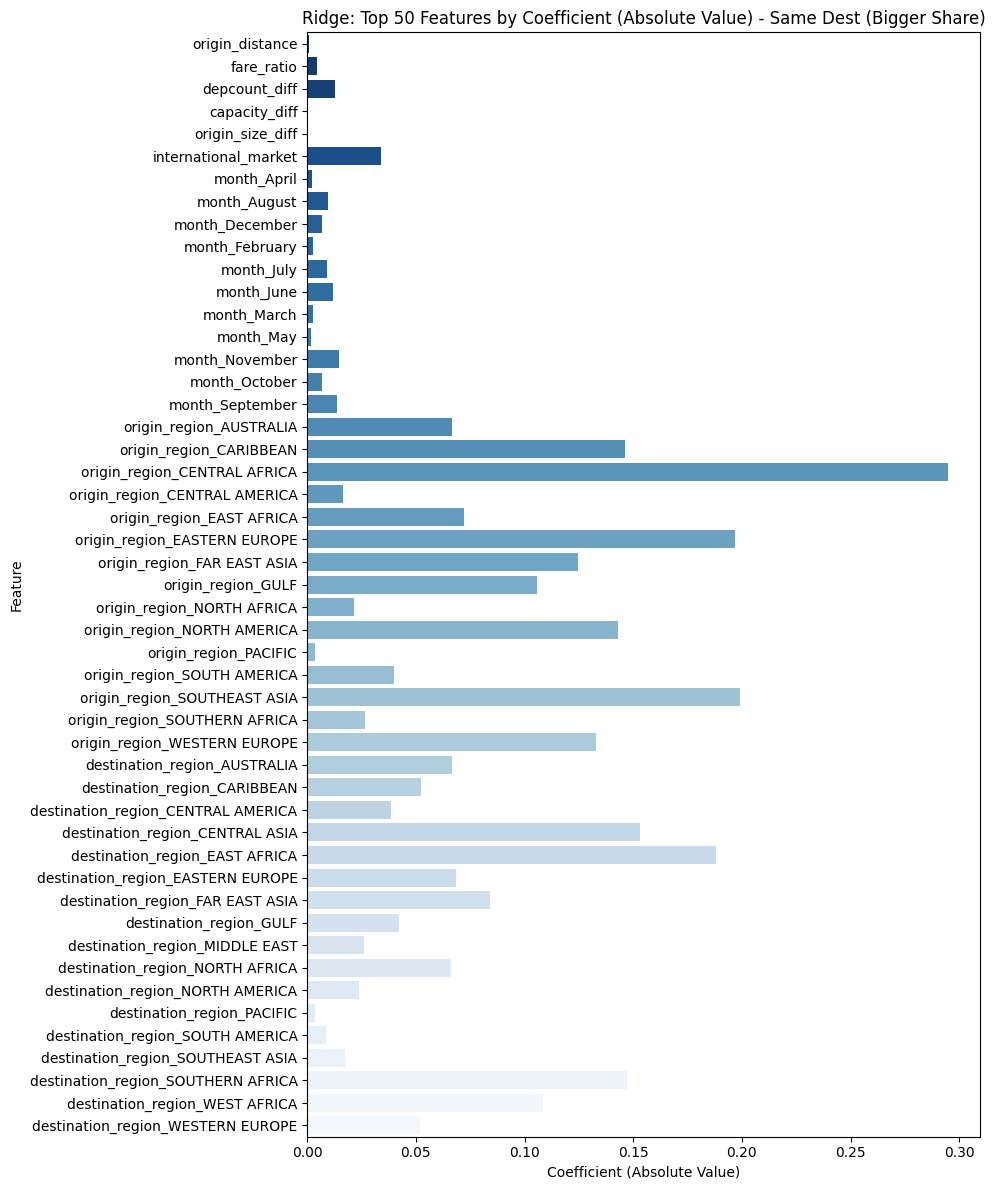

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_ridge_2, X_train, X_test, y_train, y_test, y_pred, coef_ridge_2 = run_ridge_regression(
    df_regression=df_2_apts_same_destination_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Ridge: Top 50 Features by Coefficient (Absolute Value) - Same Dest (Bigger Share)",
    y_plot_title="Ridge: Predicted vs Actual (Test Set) - Same Dest (Bigger Share)"
)


###Smaller share

SAME DESTINATION:

--- Best Alpha via RidgeCV: 1.0723 ---

--- Evaluation on Test Set ---
RMSE: 0.1259
R² Score: 0.2885

--- Top 50 Coefficients by Absolute Value ---
                           Feature   Coefficient
                   origin_distance -1.242884e-03
                        fare_ratio -1.320323e-02
                     depcount_diff  2.032589e-02
                     capacity_diff  3.145686e-05
                  origin_size_diff  6.123484e-07
              international_market -3.083631e-02
                       month_April  5.484458e-03
                      month_August  2.054617e-02
                    month_December  1.690960e-02
                    month_February -2.935003e-03
                        month_July  1.264154e-02
                        month_June  2.407837e-02
                       month_March  1.832120e-02
                         month_May  2.711256e-03
                    month_November -2.933606e-04
                     month_October  1.047919e-02


<ipython-input-47-09c1e04a4008>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.head(top_n_features)['Coefficient'].abs(), y=coef_df.head(top_n_features)['Feature'], palette='Blues_r')


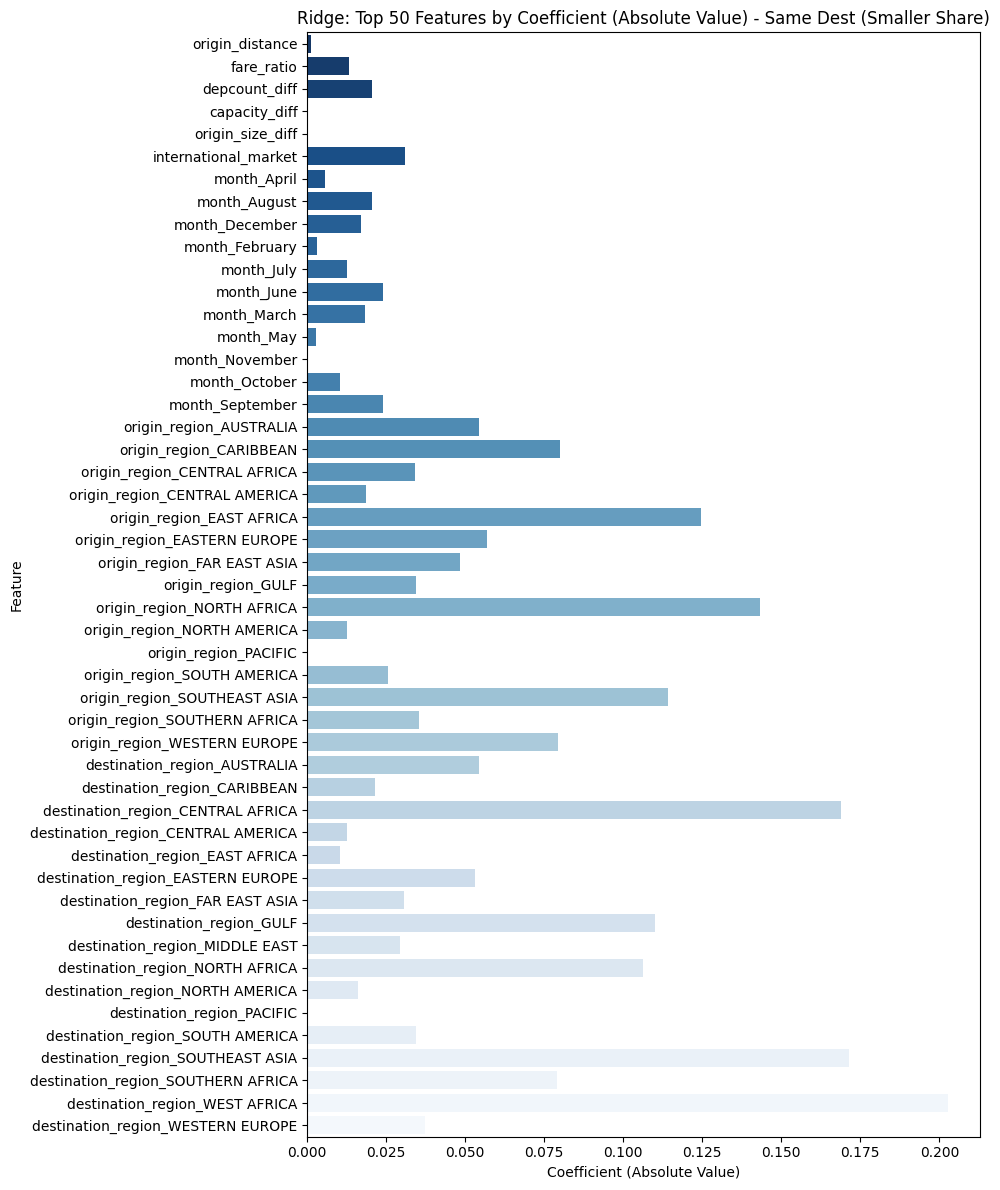

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_ridge_3, X_train, X_test, y_train, y_test, y_pred, coef_ridge_3 = run_ridge_regression(
    df_regression=df_2_apts_same_destination_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Ridge: Top 50 Features by Coefficient (Absolute Value) - Same Dest (Smaller Share)",
    y_plot_title="Ridge: Predicted vs Actual (Test Set) - Same Dest (Smaller Share)"
)


##Same Origin

SAME ORIGIN:

--- Best Alpha via RidgeCV: 0.0248 ---

--- Evaluation on Test Set ---
RMSE: 0.2197
R² Score: 0.3016

--- Top 50 Coefficients by Absolute Value ---
                           Feature   Coefficient
              destination_distance -6.044938e-04
                        fare_ratio -2.623121e-02
                     depcount_diff  2.417591e-02
                     capacity_diff  5.083594e-05
             destination_size_diff  6.144306e-07
              international_market  1.953440e-02
                       month_April  1.236178e-02
                      month_August  6.685465e-03
                    month_December  1.622112e-02
                    month_February  1.491359e-02
                        month_July -1.543545e-02
                        month_June  1.222829e-02
                       month_March  2.521316e-02
                         month_May  4.563807e-03
                    month_November  1.443406e-02
                     month_October  8.189354e-03
     

<ipython-input-47-09c1e04a4008>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.head(top_n_features)['Coefficient'].abs(), y=coef_df.head(top_n_features)['Feature'], palette='Blues_r')


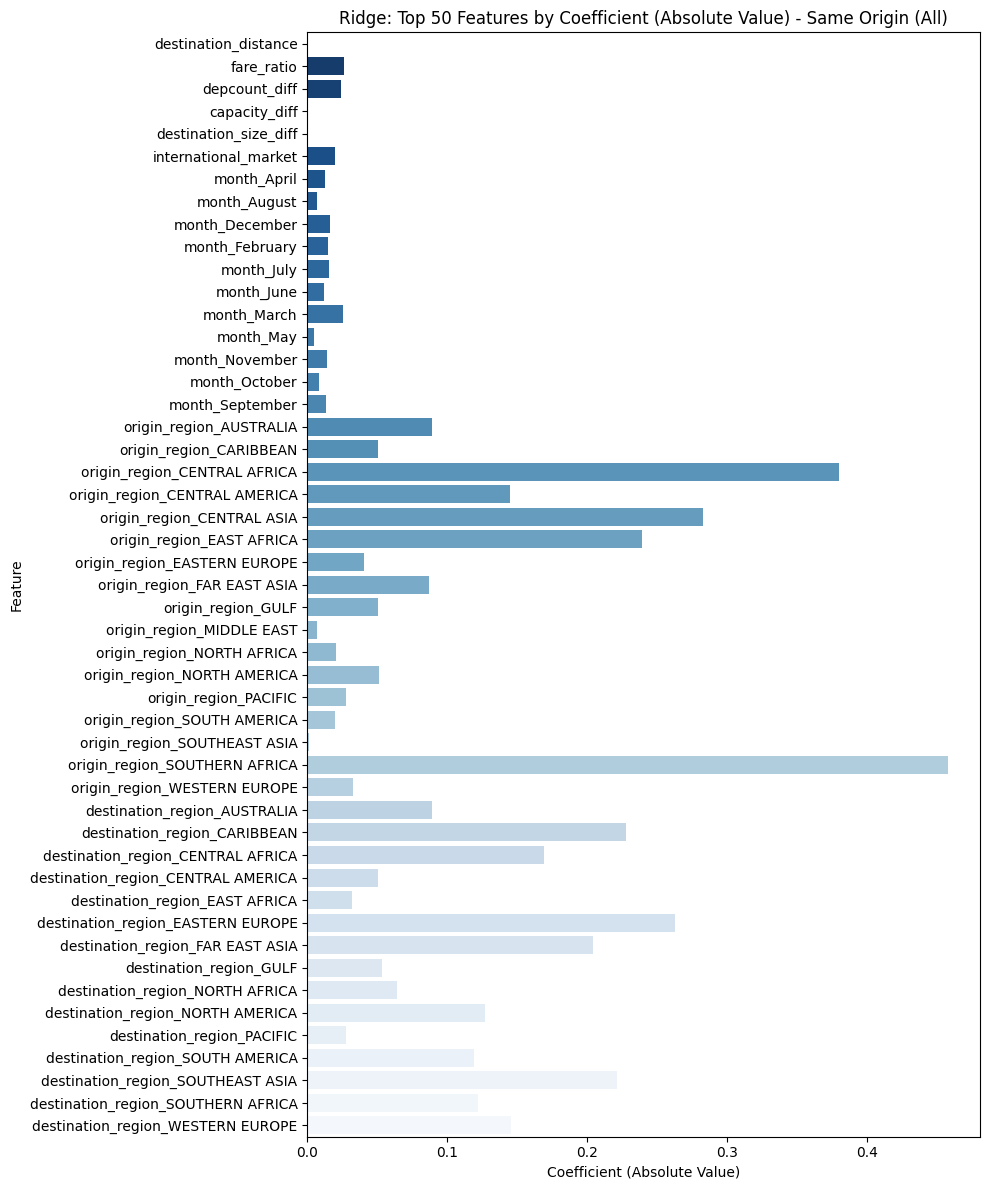

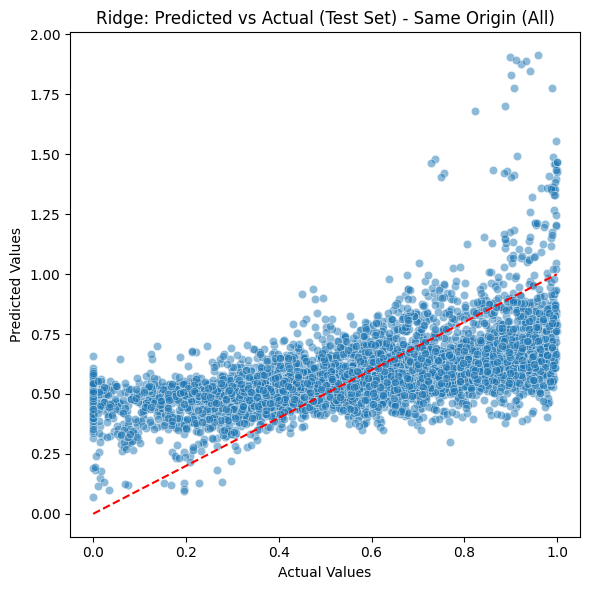

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_ridge_4, X_train, X_test, y_train, y_test, y_pred, coef_ridge_4 = run_ridge_regression(
    df_regression=df_2_apts_same_origin_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Ridge: Top 50 Features by Coefficient (Absolute Value) - Same Origin (All)",
    y_plot_title = "Ridge: Predicted vs Actual (Test Set) - Same Origin (All)"
)


###Bigger share

SAME ORIGIN:

--- Best Alpha via RidgeCV: 0.1150 ---

--- Evaluation on Test Set ---
RMSE: 0.1479
R² Score: 0.2203

--- Top 50 Coefficients by Absolute Value ---
                           Feature   Coefficient
              destination_distance -7.852448e-04
                        fare_ratio -8.181836e-05
                     depcount_diff  1.381503e-02
                     capacity_diff  6.288634e-06
             destination_size_diff  5.394791e-07
              international_market  3.313402e-02
                       month_April -3.969670e-04
                      month_August -1.338375e-02
                    month_December -1.062380e-02
                    month_February -7.698254e-04
                        month_July -1.438518e-02
                        month_June -1.466373e-02
                       month_March -2.216053e-03
                         month_May -8.310219e-03
                    month_November -1.213602e-02
                     month_October -1.002680e-02
     

<ipython-input-47-09c1e04a4008>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.head(top_n_features)['Coefficient'].abs(), y=coef_df.head(top_n_features)['Feature'], palette='Blues_r')


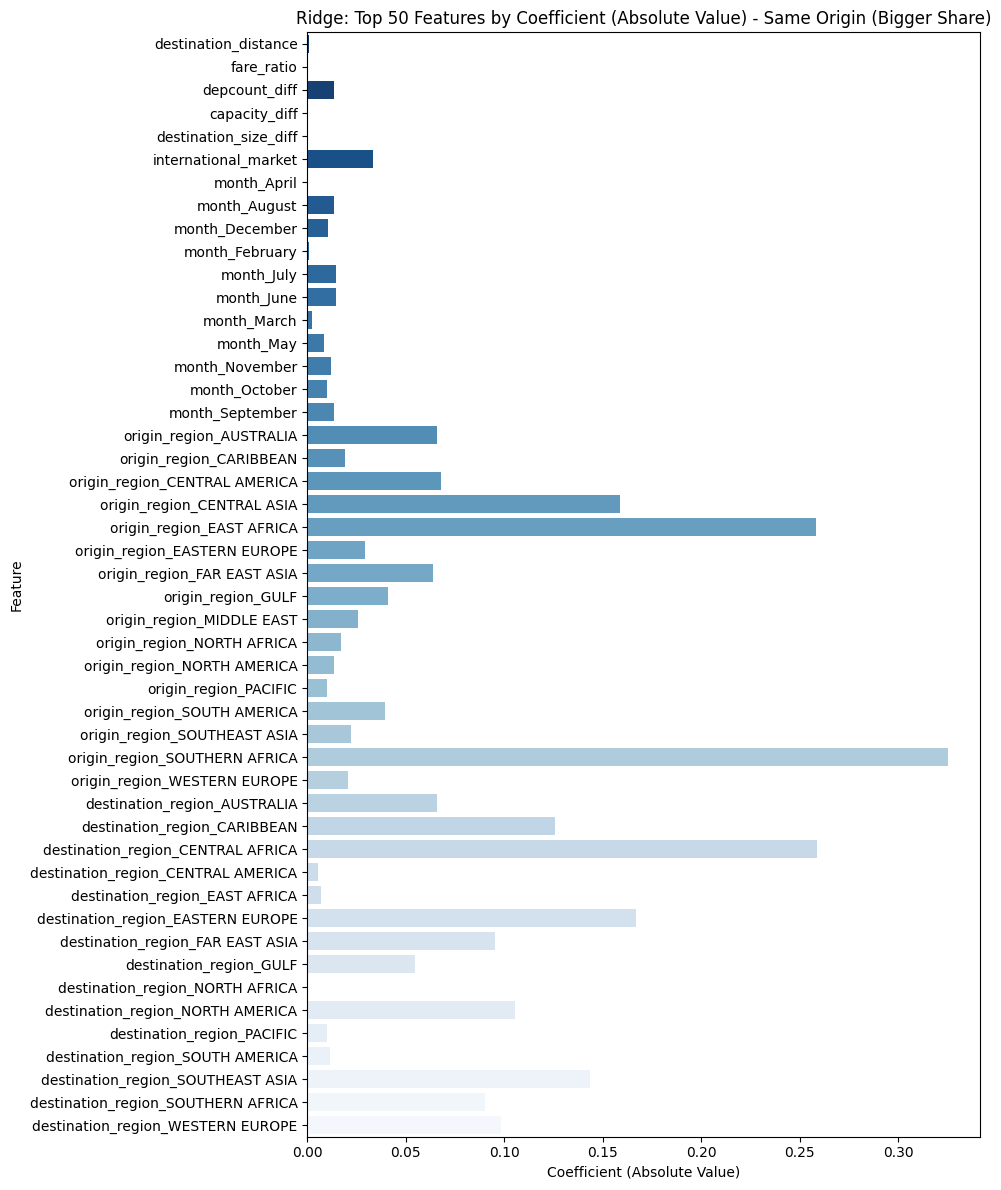

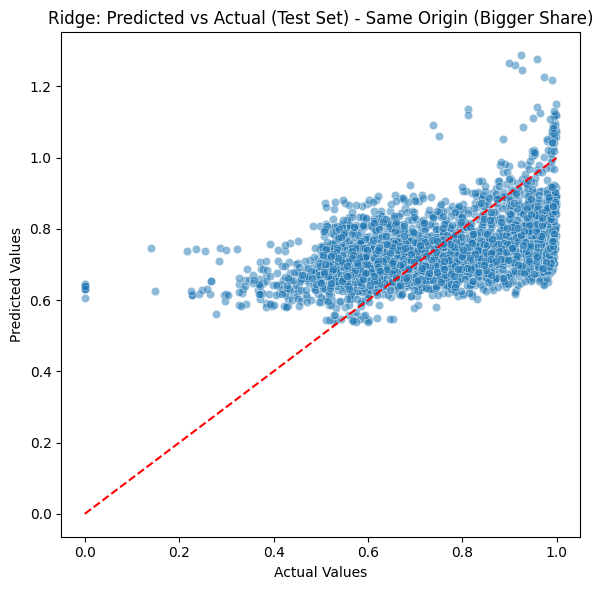

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_ridge_5, X_train, X_test, y_train, y_test, y_pred, coef_ridge_5 = run_ridge_regression(
    df_regression=df_2_apts_same_origin_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Ridge: Top 50 Features by Coefficient (Absolute Value) - Same Origin (Bigger Share)",
    y_plot_title = "Ridge: Predicted vs Actual (Test Set) - Same Origin (Bigger Share)"
)


###Smaller share

SAME ORIGIN:

--- Best Alpha via RidgeCV: 2.4771 ---

--- Evaluation on Test Set ---
RMSE: 0.1323
R² Score: 0.2249

--- Top 50 Coefficients by Absolute Value ---
                           Feature   Coefficient
              destination_distance -1.328476e-03
                        fare_ratio -1.652810e-02
                     depcount_diff  1.992874e-02
                     capacity_diff  2.495105e-05
             destination_size_diff  5.168892e-07
              international_market -4.597969e-02
                       month_April -6.408251e-05
                      month_August  2.417238e-02
                    month_December  1.249595e-02
                    month_February -8.792761e-03
                        month_July  2.532619e-03
                        month_June  2.051422e-02
                       month_March  1.900773e-02
                         month_May -3.648354e-03
                    month_November  4.271212e-03
                     month_October -7.982514e-03
     

<ipython-input-47-09c1e04a4008>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.head(top_n_features)['Coefficient'].abs(), y=coef_df.head(top_n_features)['Feature'], palette='Blues_r')


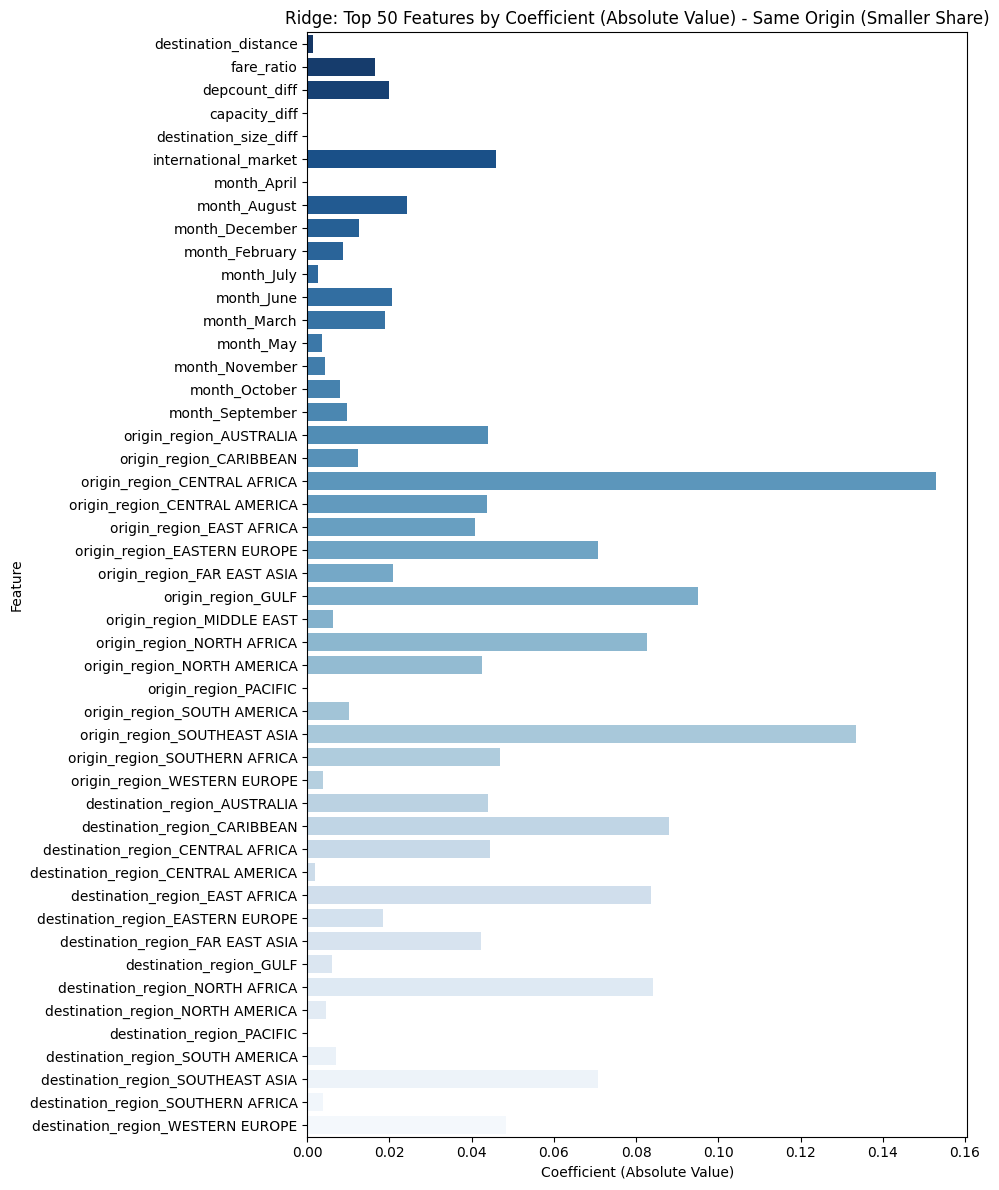

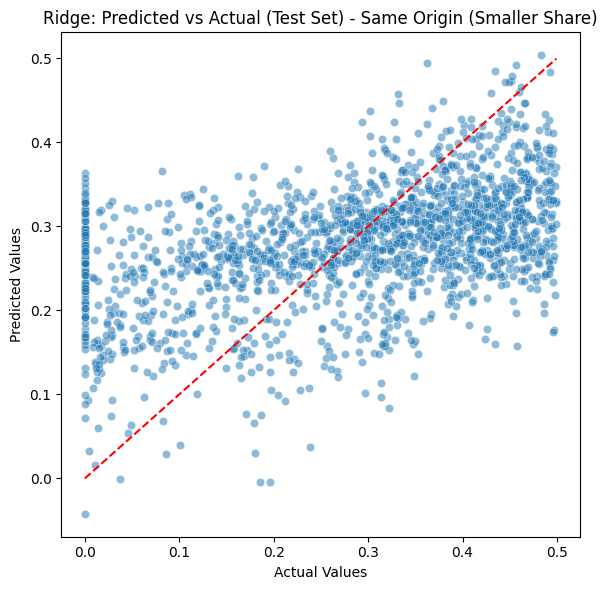

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_ridge_6, X_train, X_test, y_train, y_test, y_pred, coef_ridge_6 = run_ridge_regression(
    df_regression=df_2_apts_same_origin_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Ridge: Top 50 Features by Coefficient (Absolute Value) - Same Origin (Smaller Share)",
    y_plot_title = "Ridge: Predicted vs Actual (Test Set) - Same Origin (Smaller Share)"
)


###Summary Ridge

In [ ]:
#merge coef_ridge_1 and coef_ridge_2 based on the feature column
df_ridge_coef = []

df_ridge_coef = pd.merge(coef_ridge_1, coef_ridge_2, on='Feature', how='outer', suffixes=('_1', '_2'))
df_ridge_coef = pd.merge(df_ridge_coef, coef_ridge_3, on='Feature', how='outer', suffixes=('', '_3'))
df_ridge_coef = pd.merge(df_ridge_coef, coef_ridge_4, on='Feature', how='outer', suffixes=('', '_4'))
df_ridge_coef = pd.merge(df_ridge_coef, coef_ridge_5, on='Feature', how='outer', suffixes=('', '_5'))
df_ridge_coef = pd.merge(df_ridge_coef, coef_ridge_6, on='Feature', how='outer', suffixes=('', '_6'))

df_ridge_coef

Feature  Coefficient_1  Coefficient_2  \
0                        capacity_diff   5.336682e-05   9.718364e-06   
1                        depcount_diff   2.315371e-02   1.265613e-02   
2                 destination_distance            NaN            NaN   
3         destination_region_AUSTRALIA  -5.698491e-02  -6.645082e-02   
4         destination_region_CARIBBEAN  -4.885730e-02   5.214552e-02   
5    destination_region_CENTRAL AFRICA  -3.346923e-01            NaN   
6   destination_region_CENTRAL AMERICA  -1.116076e-01  -3.845496e-02   
7      destination_region_CENTRAL ASIA   2.872596e-01   1.532617e-01   
8       destination_region_EAST AFRICA  -1.461585e-01  -1.882925e-01   
9    destination_region_EASTERN EUROPE  -1.757366e-02   6.844891e-02   
10    destination_region_FAR EAST ASIA   7.864224e-02   8.420115e-02   
11             destination_region_GULF   9.453200e-02   4.202287e-02   
12      destination_region_MIDDLE EAST   2.617617e-02   2.624039e-02   
13     destination_region_NORTH AFRICA   4.613961e-02   6.601381e-02   
14    destination_region_NORTH AMERICA  -3.860721e-02   2.372659e-02   
15          destination_region_PACIFIC   4.305080e-02  -3.485721e-03   
16    destination_region_SOUTH AMERICA  -2.343668e-03  -8.736898e-03   
17   destination_region_SOUTHEAST ASIA   6.035660e-03   1.738571e-02   
18  destination_region_SOUTHERN AFRICA  -1.827513e-01  -1.473454e-01   
19      destination_region_WEST AFRICA  -5.097333e-01  -1.082741e-01   
20   destination_region_WESTERN EUROPE  -1.269872e-02   5.199173e-02   
21               destination_size_diff            NaN            NaN   
22                          fare_ratio  -2.681734e-02   4.264416e-03   
23                international_market   2.046714e-02   3.415595e-02   
24                         month_April   3.648347e-03   2.195726e-03   
25                        month_August   2.414208e-03  -9.715084e-03   
26                      month_December   1.570070e-02  -6.581122e-03   
27                      month_February   1.245364e-02   2.631154e-03   
28                          month_July  -1.081163e-02  -9.227739e-03   
29                          month_June   8.807196e-03  -1.186848e-02   
30                         month_March   2.256124e-02   2.438780e-03   
31                           month_May  -3.562679e-03   1.720291e-03   
32                      month_November  -1.526043e-04  -1.438764e-02   
33                       month_October   8.070094e-03  -6.818292e-03   
34                     month_September   4.445936e-03  -1.373623e-02   
35                     origin_distance  -4.276626e-04  -8.369206e-04   
36             origin_region_AUSTRALIA  -5.698491e-02  -6.645082e-02   
37             origin_region_CARIBBEAN  -1.720003e-01  -1.462301e-01   
38        origin_region_CENTRAL AFRICA  -1.367922e-01  -2.948526e-01   
39       origin_region_CENTRAL AMERICA   7.825580e-02  -1.655820e-02   
40          origin_region_CENTRAL ASIA            NaN            NaN   
41           origin_region_EAST AFRICA  -2.391338e-02  -7.227086e-02   
42        origin_region_EASTERN EUROPE  -2.311796e-01  -1.968507e-01   
43         origin_region_FAR EAST ASIA  -1.352244e-01  -1.247233e-01   
44                  origin_region_GULF  -3.368053e-02  -1.058738e-01   
45           origin_region_MIDDLE EAST            NaN            NaN   
46          origin_region_NORTH AFRICA  -1.727842e-01  -2.127653e-02   
47         origin_region_NORTH AMERICA  -8.572905e-02  -1.428849e-01   
48               origin_region_PACIFIC   4.305080e-02  -3.485721e-03   
49         origin_region_SOUTH AMERICA  -6.891916e-02  -3.989965e-02   
50        origin_region_SOUTHEAST ASIA  -1.907773e-01  -1.992697e-01   
51       origin_region_SOUTHERN AFRICA   4.170390e-02   2.635382e-02   
52        origin_region_WESTERN EUROPE  -1.209786e-01  -1.329175e-01   
53                    origin_size_diff   5.987390e-07   4.999848e-07   

     Coefficient  Coefficient_4  Coefficient_5  Coefficient_6  
0   3.

In [ ]:
#Create a latex table from df_ridge_coef
df_ridge_coef.to_latex('ridge_coef.tex')

#Lasso Regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


def run_lasso_regression(
    df_regression,
    target='1_percentage_Passengers',
    drop_columns=None,
    test_size=0.3,
    random_state=42,
    alphas=np.logspace(-3, 3, 100),
    top_n_features=20,
    coef_plot_title="LassoCV: Top Non-Zero Features by Coefficient (Absolute Value)",
    y_plot_title="LassoCV: Predicted vs Actual (Test Set)"
):
    df_model = df_regression.copy()
    if drop_columns:
        df_model = df_model.drop(columns=drop_columns, errors='ignore')

    X = df_model.drop(columns=[target])
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- Best Alpha via LassoCV: {model.alpha_:.4f} ---")
    print("\n--- Evaluation on Test Set ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    })#.sort_values(by="Coefficient", key=lambda x: abs(x), ascending=False)


    # === Plot: Top N Non-Zero Coefficients ===
    nonzero_coefs = coef_df[coef_df['Coefficient'] != 0]
    nonzero_coefs = nonzero_coefs.sort_values(by="Coefficient", key=lambda x: abs(x), ascending=False)

    print(f"\n--- {len(nonzero_coefs)} Non-Zero Coefficients ---")
    print(nonzero_coefs.head(top_n_features).to_string(index=False))

    top_coefs = nonzero_coefs.head(top_n_features)

    # Plot signed coefficients
    # top_coefs = nonzero_coefs.head(top_n_features)
    plt.figure(figsize=(9, max(6, 0.4 * top_n_features)))
    sns.barplot(x="Coefficient", y="Feature", data=top_coefs,
                palette="coolwarm", dodge=False)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(coef_plot_title)
    plt.xlabel("Coefficient Value (Signed)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Plot testing results
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(y_plot_title)
    plt.tight_layout()
    plt.show()

    return model, X_train, X_test, y_train, y_test, y_pred, coef_df



##Same Destination

SAME DESTINATION:

--- Best Alpha via LassoCV: 0.0010 ---

--- Evaluation on Test Set ---
RMSE: 0.2219
R² Score: 0.3045

--- 19 Non-Zero Coefficients ---
                          Feature   Coefficient
     origin_region_EASTERN EUROPE -9.512215e-02
               origin_region_GULF  3.295456e-02
 destination_region_FAR EAST ASIA  2.931519e-02
          destination_region_GULF  2.816917e-02
     origin_region_SOUTHEAST ASIA -2.479290e-02
                       fare_ratio -2.421543e-02
                    depcount_diff  2.108954e-02
 destination_region_SOUTH AMERICA  1.838334e-02
 destination_region_NORTH AMERICA -1.636957e-02
     destination_region_CARIBBEAN -1.358737e-02
destination_region_WESTERN EUROPE -1.033445e-02
             international_market  6.161674e-03
                      month_March  5.554135e-03
                       month_July -5.185929e-03
     origin_region_WESTERN EUROPE -4.003536e-03
                  origin_distance -3.734945e-04
                   month_Decem

<ipython-input-65-3398048a485d>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=top_coefs,


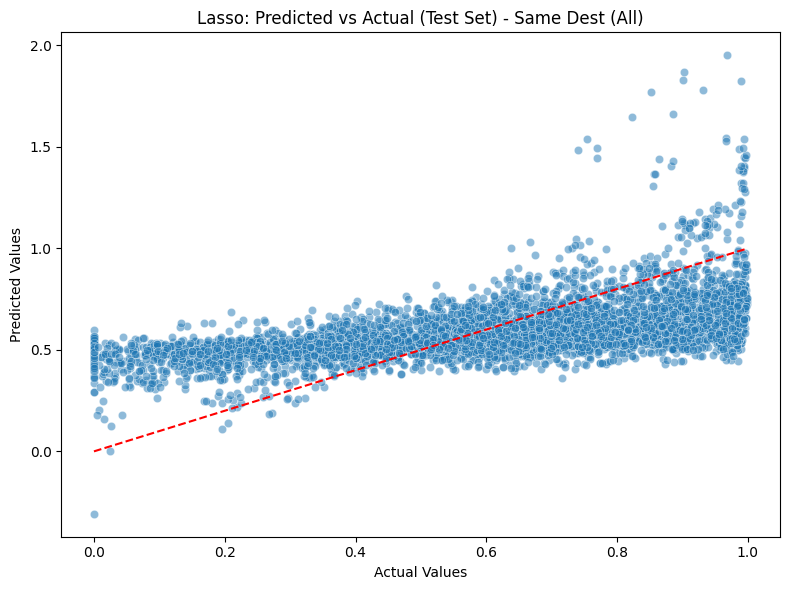

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_lasso_1, X_train, X_test, y_train, y_test, y_pred, lasso_coef_1 = run_lasso_regression(
    df_regression=df_2_apts_same_destination_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Lasso: Top Non-Zero Features by Coefficient - Same Dest (All)",
    y_plot_title = "Lasso: Predicted vs Actual (Test Set) - Same Dest (All)"
)


###Bigger share

SAME DESTINATION:

--- Best Alpha via LassoCV: 0.0010 ---

--- Evaluation on Test Set ---
RMSE: 0.1470
R² Score: 0.2004

--- 11 Non-Zero Coefficients ---
                         Feature   Coefficient
    origin_region_SOUTHEAST ASIA -4.659236e-02
    origin_region_EASTERN EUROPE -3.656928e-02
     origin_region_NORTH AMERICA -2.355527e-02
destination_region_NORTH AMERICA -1.946942e-02
            international_market  1.906927e-02
destination_region_FAR EAST ASIA  1.418343e-02
                   depcount_diff  1.227702e-02
                      fare_ratio  1.989345e-03
                 origin_distance -7.536548e-04
                   capacity_diff  1.117804e-05
                origin_size_diff  4.903530e-07


<ipython-input-65-3398048a485d>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=top_coefs,


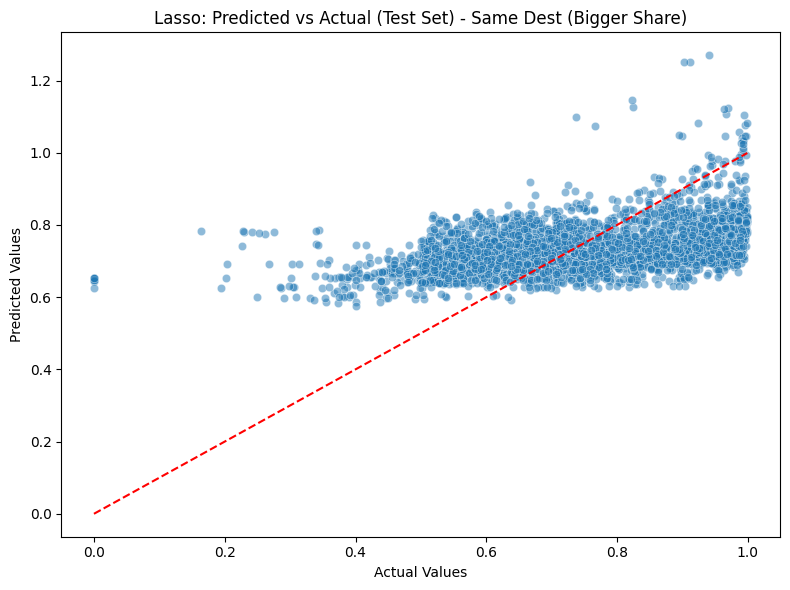

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_lasso_2, X_train, X_test, y_train, y_test, y_pred, lasso_coef_2 = run_lasso_regression(
    df_regression=df_2_apts_same_destination_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Lasso: Top Non-Zero Features by Coefficient - Same Dest (Bigger Share)",
    y_plot_title="Lasso: Predicted vs Actual (Test Set) - Same Dest (Bigger Share)"
)


###Smaller share

SAME DESTINATION:

--- Best Alpha via LassoCV: 0.0010 ---

--- Evaluation on Test Set ---
RMSE: 0.1308
R² Score: 0.2316

--- 14 Non-Zero Coefficients ---
                          Feature   Coefficient
destination_region_EASTERN EUROPE -7.241894e-02
     origin_region_WESTERN EUROPE -3.227825e-02
destination_region_SOUTHEAST ASIA  2.702503e-02
             international_market -2.463373e-02
  destination_region_NORTH AFRICA  2.360312e-02
                    depcount_diff  1.946477e-02
                       fare_ratio -1.181494e-02
 destination_region_NORTH AMERICA -9.594776e-03
   destination_region_WEST AFRICA -2.250009e-03
                   month_February -1.815249e-03
                  origin_distance -1.394634e-03
                  month_September  1.102849e-03
                    capacity_diff  1.981830e-05
                 origin_size_diff  6.272722e-07


<ipython-input-65-3398048a485d>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=top_coefs,


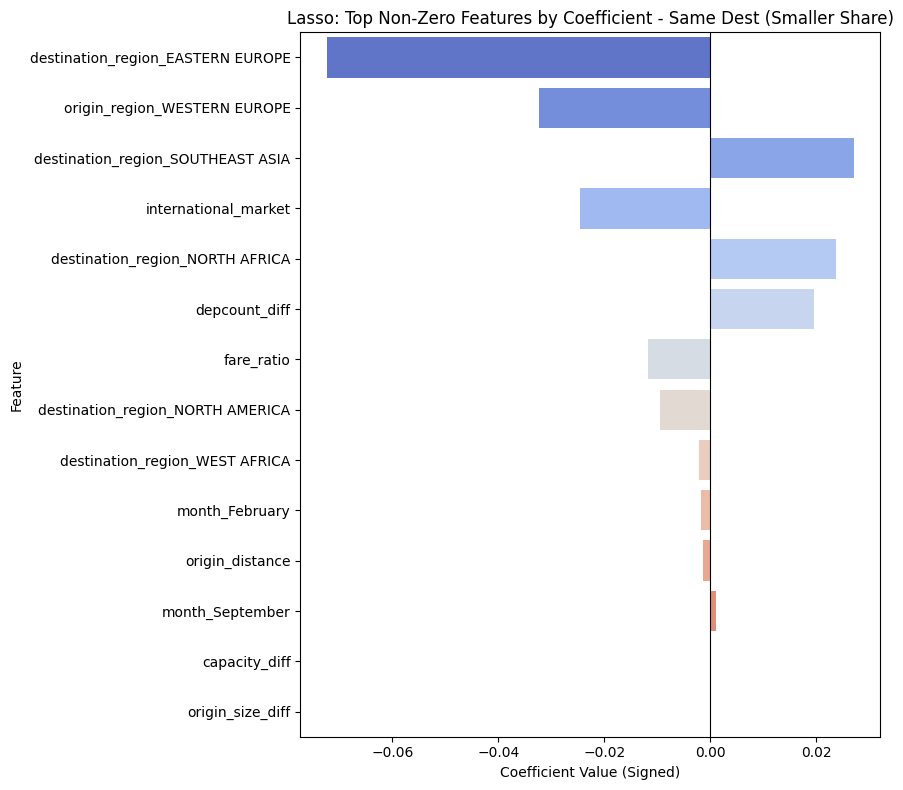

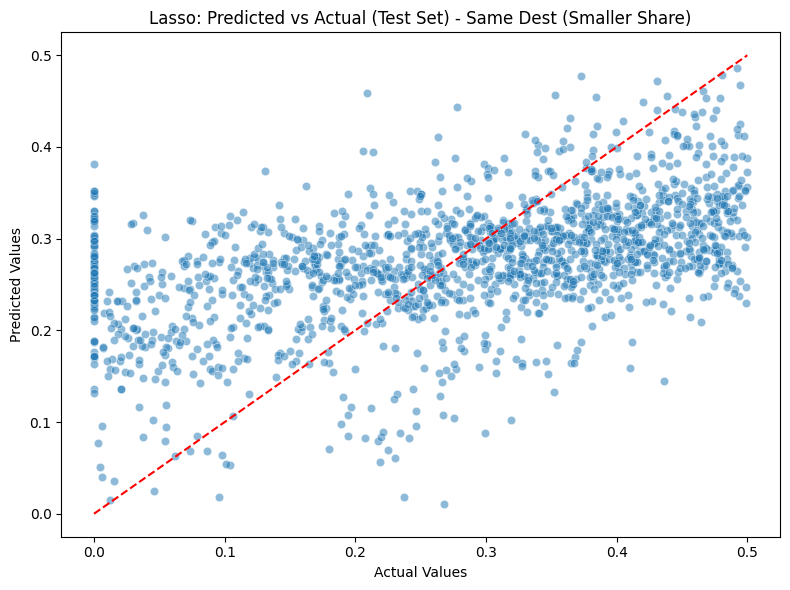

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_lasso_3, X_train, X_test, y_train, y_test, y_pred, lasso_coef_3 = run_lasso_regression(
    df_regression=df_2_apts_same_destination_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Lasso: Top Non-Zero Features by Coefficient - Same Dest (Smaller Share)",
    y_plot_title="Lasso: Predicted vs Actual (Test Set) - Same Dest (Smaller Share)"
)


##Same Origin

SAME ORIGIN:

--- Best Alpha via LassoCV: 0.0010 ---

--- Evaluation on Test Set ---
RMSE: 0.2223
R² Score: 0.2854

--- 18 Non-Zero Coefficients ---
                          Feature   Coefficient
destination_region_EASTERN EUROPE -1.011009e-01
          destination_region_GULF  3.400983e-02
      origin_region_FAR EAST ASIA  2.926234e-02
                       fare_ratio -2.422702e-02
                    depcount_diff  2.181665e-02
      origin_region_NORTH AMERICA -2.106542e-02
               origin_region_GULF  1.904505e-02
                       month_July -1.444825e-02
destination_region_SOUTHEAST ASIA -1.288186e-02
    origin_region_CENTRAL AMERICA -9.260661e-03
     origin_region_WESTERN EUROPE -7.822663e-03
             international_market  7.258491e-03
          origin_region_CARIBBEAN -7.088294e-03
                      month_March  3.109969e-03
      origin_region_SOUTH AMERICA  2.490673e-03
             destination_distance -5.561981e-04
                    capacity_diff  

<ipython-input-65-3398048a485d>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=top_coefs,


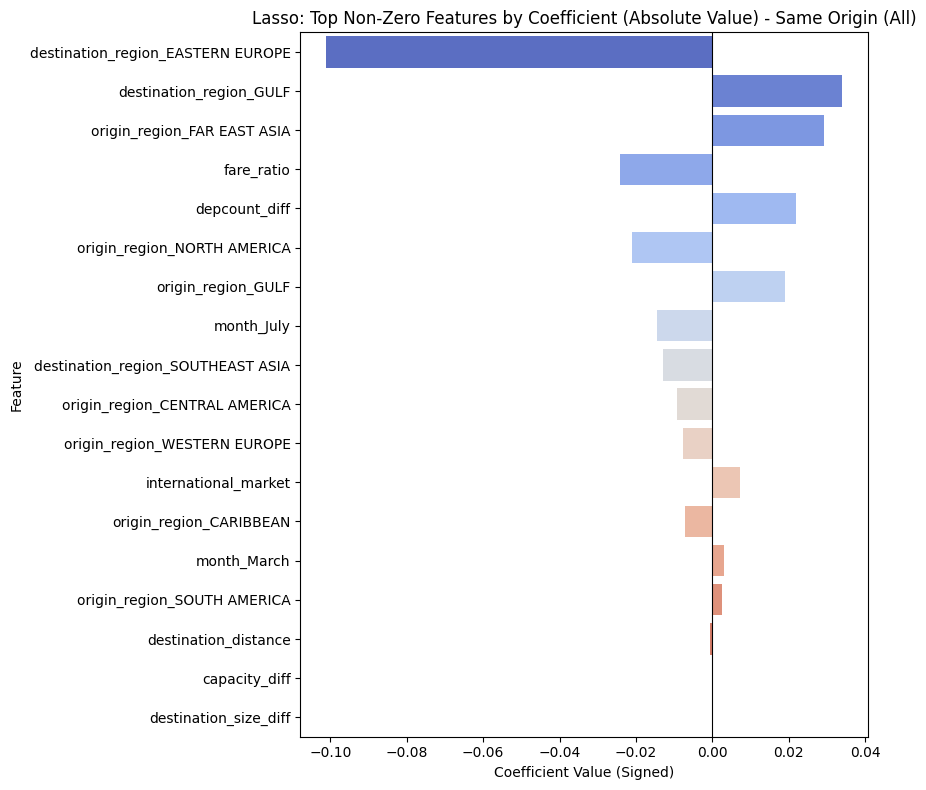

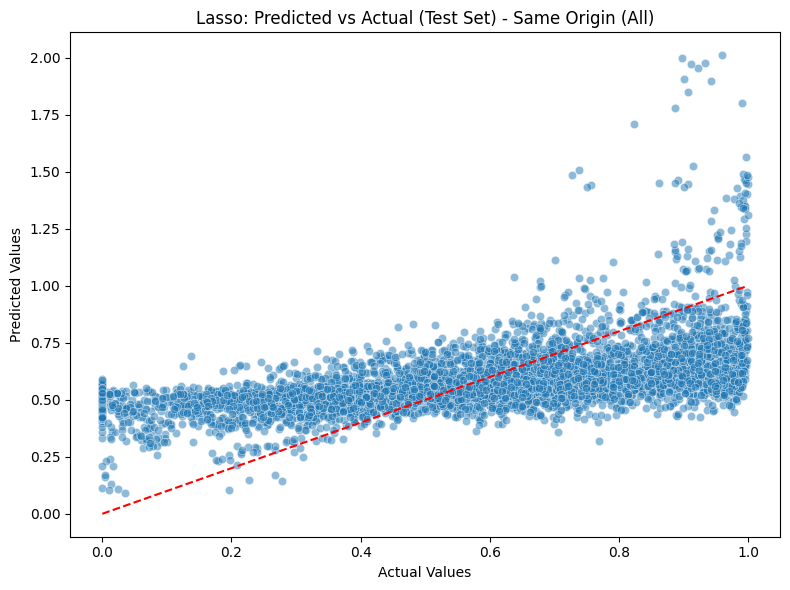

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_lasso_4, X_train, X_test, y_train, y_test, y_pred, lasso_coef_4 = run_lasso_regression(
    df_regression=df_2_apts_same_origin_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Lasso: Top Non-Zero Features by Coefficient (Absolute Value) - Same Origin (All)",
    y_plot_title = "Lasso: Predicted vs Actual (Test Set) - Same Origin (All)"
)


###Bigger share

SAME ORIGIN:

--- Best Alpha via LassoCV: 0.0010 ---

--- Evaluation on Test Set ---
RMSE: 0.1503
R² Score: 0.1947

--- 11 Non-Zero Coefficients ---
                          Feature   Coefficient
destination_region_EASTERN EUROPE -4.023187e-02
      origin_region_NORTH AMERICA -2.646317e-02
      origin_region_FAR EAST ASIA  2.340906e-02
destination_region_SOUTHEAST ASIA -2.174488e-02
             international_market  1.919639e-02
 destination_region_NORTH AMERICA -1.609647e-02
                    depcount_diff  1.254505e-02
             destination_distance -6.928278e-04
     origin_region_WESTERN EUROPE  4.216388e-04
                    capacity_diff  1.243958e-05
            destination_size_diff  5.691279e-07


<ipython-input-65-3398048a485d>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=top_coefs,


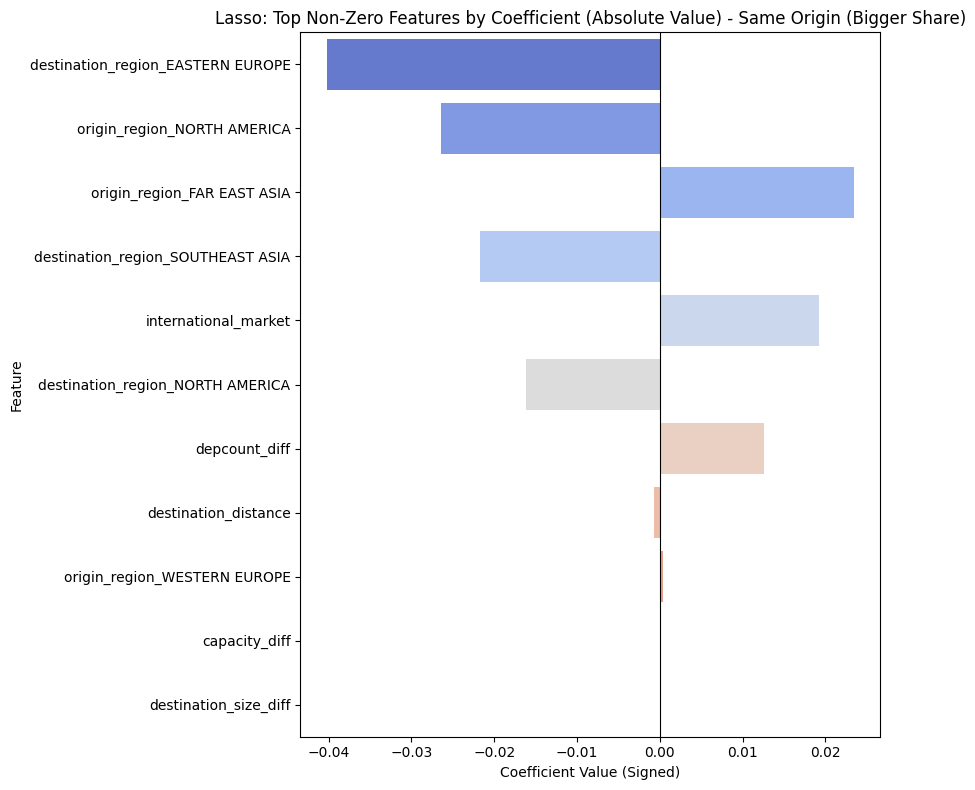

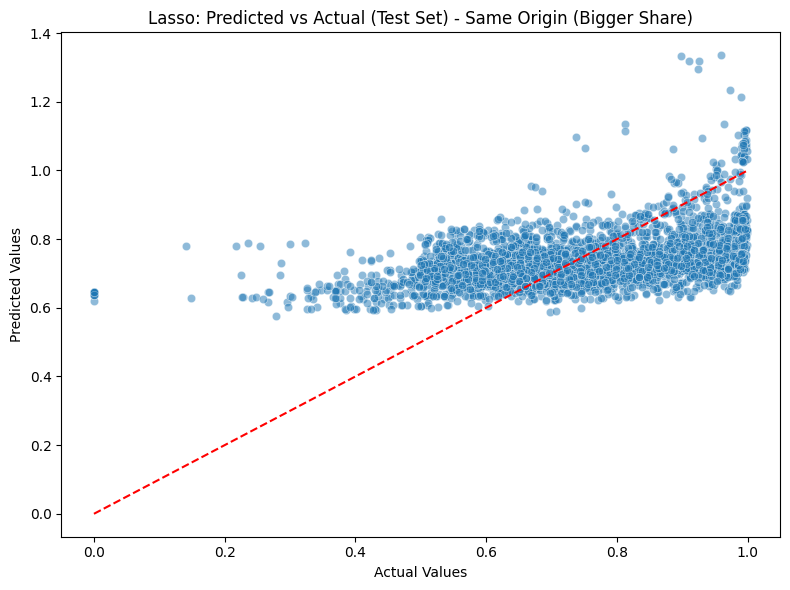

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_lasso_5, X_train, X_test, y_train, y_test, y_pred, lasso_coef_5= run_lasso_regression(
    df_regression=df_2_apts_same_origin_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Lasso: Top Non-Zero Features by Coefficient (Absolute Value) - Same Origin (Bigger Share)",
    y_plot_title = "Lasso: Predicted vs Actual (Test Set) - Same Origin (Bigger Share)"
)


###Smaller share

SAME ORIGIN:

--- Best Alpha via LassoCV: 0.0010 ---

--- Evaluation on Test Set ---
RMSE: 0.1334
R² Score: 0.2113

--- 18 Non-Zero Coefficients ---
                          Feature   Coefficient
     origin_region_EASTERN EUROPE -6.220436e-02
             international_market -3.266098e-02
     origin_region_SOUTHEAST ASIA  3.185201e-02
       origin_region_NORTH AFRICA  2.553819e-02
destination_region_WESTERN EUROPE -2.408245e-02
                    depcount_diff  1.839197e-02
                       fare_ratio -1.544943e-02
      origin_region_NORTH AMERICA -1.531300e-02
     destination_region_CARIBBEAN -1.367174e-02
                     month_August  6.555271e-03
     origin_region_WESTERN EUROPE -4.392419e-03
                   month_February -2.234917e-03
                    month_October -1.661931e-03
                       month_June  1.480253e-03
             destination_distance -1.468562e-03
                      month_March  6.254548e-04
                    capacity_diff  

<ipython-input-65-3398048a485d>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=top_coefs,


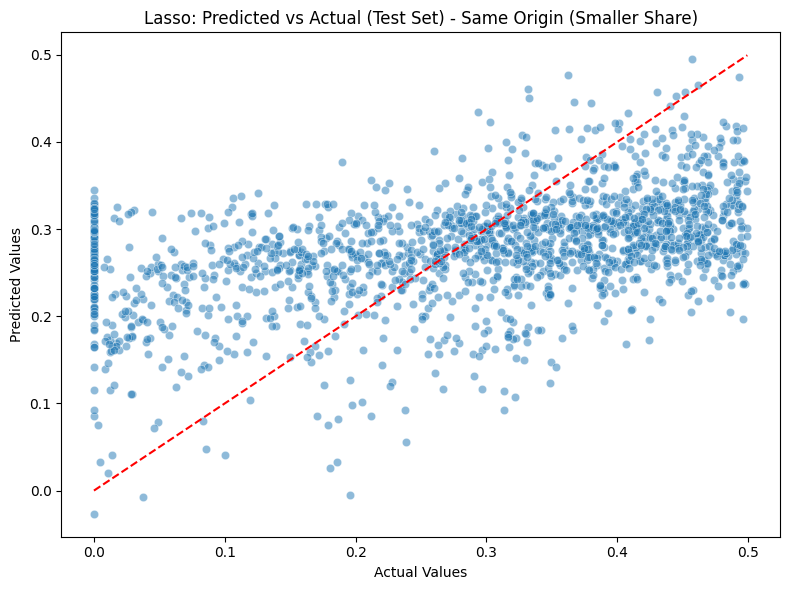

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_lasso_6, X_train, X_test, y_train, y_test, y_pred, lasso_coef_6 = run_lasso_regression(
    df_regression=df_2_apts_same_origin_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Lasso: Top Non-Zero Features by Coefficient (Absolute Value) - Same Origin (Smaller Share)",
    y_plot_title = "Lasso: Predicted vs Actual (Test Set) - Same Origin (Smaller Share)"
)


###Summary Lasso

In [ ]:
df_lasso_coefs = []

df_lasso_coefs = pd.merge(lasso_coef_1, lasso_coef_2, on='Feature', how='outer', suffixes=('_1', '_2'))
df_lasso_coefs = pd.merge(df_lasso_coefs, lasso_coef_3, on='Feature', how='outer', suffixes=('', '_3'))
df_lasso_coefs = pd.merge(df_lasso_coefs, lasso_coef_4, on='Feature', how='outer', suffixes=('', '_4'))
df_lasso_coefs = pd.merge(df_lasso_coefs, lasso_coef_5, on='Feature', how='outer', suffixes=('', '_5'))
df_lasso_coefs = pd.merge(df_lasso_coefs, lasso_coef_6, on='Feature', how='outer', suffixes=('', '_6'))

df_lasso_coefs

Feature  Coefficient_1  Coefficient_2  \
0                        capacity_diff   6.732861e-05   1.117804e-05   
1                        depcount_diff   2.108954e-02   1.227702e-02   
2                 destination_distance            NaN            NaN   
3         destination_region_AUSTRALIA  -0.000000e+00  -0.000000e+00   
4         destination_region_CARIBBEAN  -1.358737e-02   0.000000e+00   
5    destination_region_CENTRAL AFRICA  -0.000000e+00            NaN   
6   destination_region_CENTRAL AMERICA  -0.000000e+00  -0.000000e+00   
7      destination_region_CENTRAL ASIA   0.000000e+00   0.000000e+00   
8       destination_region_EAST AFRICA  -0.000000e+00  -0.000000e+00   
9    destination_region_EASTERN EUROPE  -0.000000e+00   0.000000e+00   
10    destination_region_FAR EAST ASIA   2.931519e-02   1.418343e-02   
11             destination_region_GULF   2.816917e-02   0.000000e+00   
12      destination_region_MIDDLE EAST   0.000000e+00  -0.000000e+00   
13     destination_region_NORTH AFRICA   0.000000e+00   0.000000e+00   
14    destination_region_NORTH AMERICA  -1.636957e-02  -1.946942e-02   
15          destination_region_PACIFIC   0.000000e+00   0.000000e+00   
16    destination_region_SOUTH AMERICA   1.838334e-02   0.000000e+00   
17   destination_region_SOUTHEAST ASIA  -0.000000e+00  -0.000000e+00   
18  destination_region_SOUTHERN AFRICA  -0.000000e+00  -0.000000e+00   
19      destination_region_WEST AFRICA  -0.000000e+00  -0.000000e+00   
20   destination_region_WESTERN EUROPE  -1.033445e-02   0.000000e+00   
21               destination_size_diff            NaN            NaN   
22                          fare_ratio  -2.421543e-02   1.989345e-03   
23                international_market   6.161674e-03   1.906927e-02   
24                         month_April  -0.000000e+00   0.000000e+00   
25                        month_August  -0.000000e+00  -0.000000e+00   
26                      month_December   2.732151e-04  -0.000000e+00   
27                      month_February   0.000000e+00   0.000000e+00   
28                          month_July  -5.185929e-03  -0.000000e+00   
29                          month_June   0.000000e+00  -0.000000e+00   
30                         month_March   5.554135e-03   0.000000e+00   
31                           month_May  -0.000000e+00   0.000000e+00   
32                      month_November  -0.000000e+00  -0.000000e+00   
33                       month_October   0.000000e+00  -0.000000e+00   
34                     month_September  -0.000000e+00  -0.000000e+00   
35                     origin_distance  -3.734945e-04  -7.536548e-04   
36             origin_region_AUSTRALIA  -0.000000e+00  -0.000000e+00   
37             origin_region_CARIBBEAN  -0.000000e+00  -0.000000e+00   
38        origin_region_CENTRAL AFRICA  -0.000000e+00  -0.000000e+00   
39       origin_region_CENTRAL AMERICA   0.000000e+00   0.000000e+00   
40          origin_region_CENTRAL ASIA            NaN            NaN   
41           origin_region_EAST AFRICA  -0.000000e+00  -0.000000e+00   
42        origin_region_EASTERN EUROPE  -9.512215e-02  -3.656928e-02   
43         origin_region_FAR EAST ASIA   0.000000e+00   0.000000e+00   
44                  origin_region_GULF   3.295456e-02   0.000000e+00   
45           origin_region_MIDDLE EAST            NaN            NaN   
46          origin_region_NORTH AFRICA  -0.000000e+00   0.000000e+00   
47         origin_region_NORTH AMERICA   0.000000e+00  -2.355527e-02   
48               origin_region_PACIFIC   0.000000e+00   0.000000e+00   
49         origin_region_SOUTH AMERICA   0.000000e+00   0.000000e+00   
50        origin_region_SOUTHEAST ASIA  -2.479290e-02  -4.659236e-02   
51       origin_region_SOUTHERN AFRICA  -0.000000e+00  -0.000000e+00   
52        origin_region_WESTERN EUROPE  -4.003536e-03   0.000000e+00   
53                    origin_size_diff   6.252092e-07   4.903530e-07   

     Coefficient  Coefficient_4  Coefficient_5  Coefficient_6  
0   1.

In [ ]:
df_lasso_coefs.to_latex('lasso_coef.tex')

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_random_forest_regression(
    df_regression,
    target='1_percentage_Passengers',
    drop_columns=None,
    test_size=0.3,
    random_state=42,
    n_estimators=100,
    max_depth=None,
    top_n_features=10,
    coef_plot_title="Random Forest: Top 50 Features by Importance",
    y_plot_title="Random Forest: Predicted vs Actual (Test Set)"
):
    df_model = df_regression.copy()
    if drop_columns:
        df_model = df_model.drop(columns=drop_columns, errors='ignore')

    X = df_model.drop(columns=[target])
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("\n--- Evaluation on Test Set ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importance summary
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": model.feature_importances_
    })#.sort_values(by="Importance", ascending=False)

    print(f"\n--- Top {top_n_features} Features by Importance ---")
    print(importance_df.head(top_n_features).to_string(index=False))

    # === Plot: Top N Importances ===
    top_importances = importance_df.head(top_n_features)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')
    plt.title(coef_plot_title)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # === Plot: Predicted vs Actual ===
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(y_plot_title)
    plt.tight_layout()
    plt.show()

    return model, X_train, X_test, y_train, y_test, y_pred, importance_df


##Same Destination

SAME DESTINATION:

--- Evaluation on Test Set ---
RMSE: 0.1038
R² Score: 0.8478

--- Top 10 Features by Importance ---
             Feature  Importance
     origin_distance    0.065287
          fare_ratio    0.065303
       depcount_diff    0.092102
       capacity_diff    0.587593
    origin_size_diff    0.078707
international_market    0.010319
         month_April    0.002498
        month_August    0.002458
      month_December    0.002144
      month_February    0.002225


<ipython-input-82-2e4620dac813>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


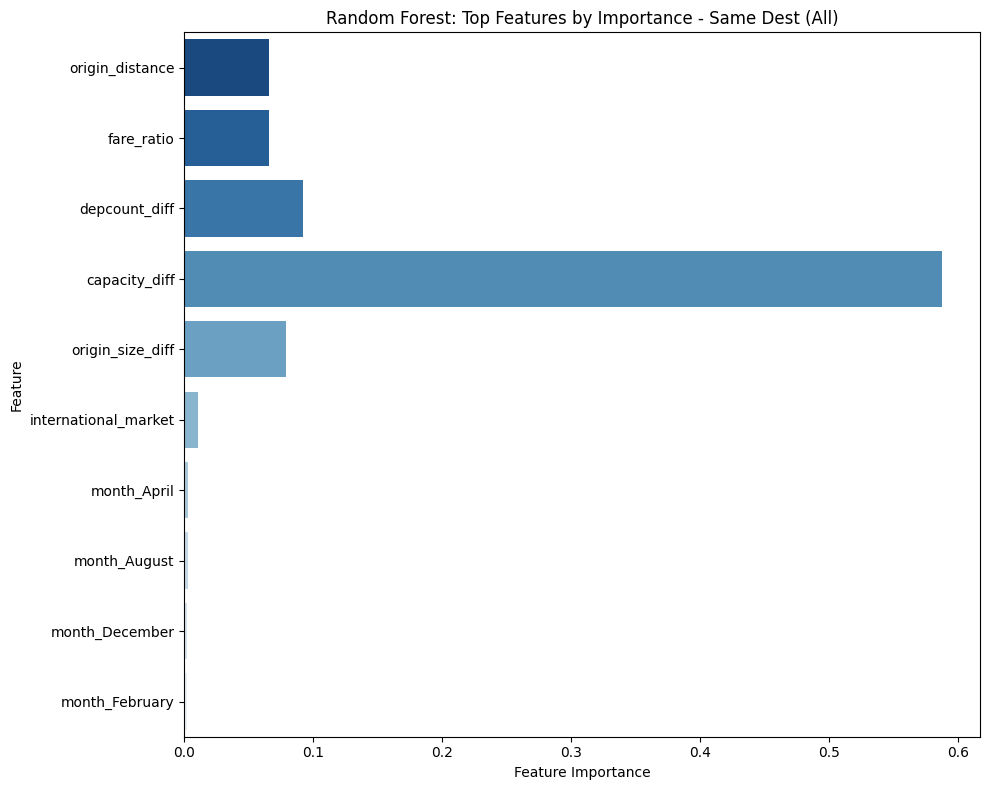

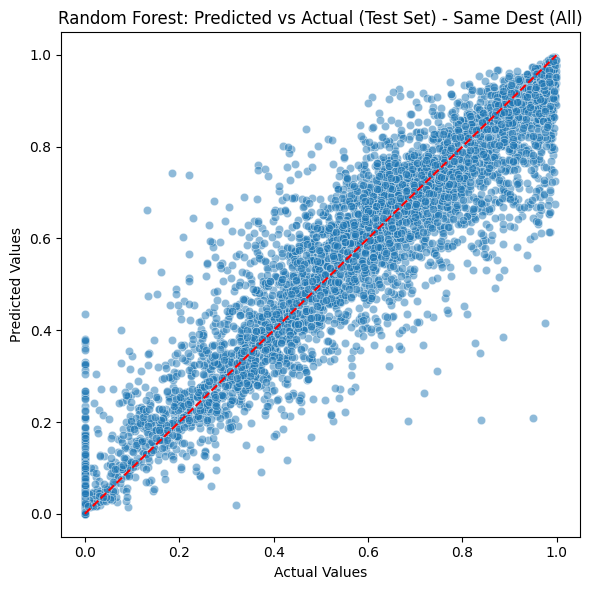

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_rf_1, X_train, X_test, y_train, y_test, y_pred, rf_imp_1 = run_random_forest_regression(
    df_regression=df_2_apts_same_destination_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Random Forest: Top Features by Importance - Same Dest (All)",
    y_plot_title = "Random Forest: Predicted vs Actual (Test Set) - Same Dest (All)"
)


###Bigger share

SAME DESTINATION:

--- Evaluation on Test Set ---
RMSE: 0.0868
R² Score: 0.7215

--- Top 10 Features by Importance ---
             Feature  Importance
     origin_distance    0.129561
          fare_ratio    0.111443
       depcount_diff    0.115626
       capacity_diff    0.326076
    origin_size_diff    0.133625
international_market    0.021631
         month_April    0.003923
        month_August    0.004582
      month_December    0.005059
      month_February    0.004634


<ipython-input-82-2e4620dac813>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


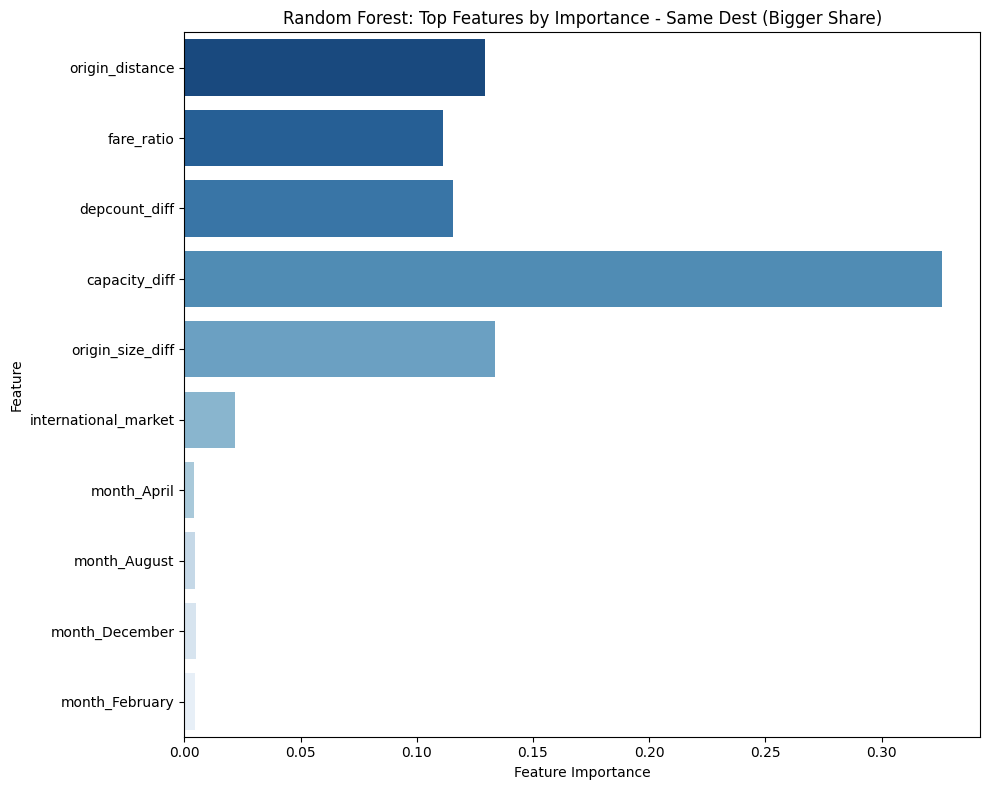

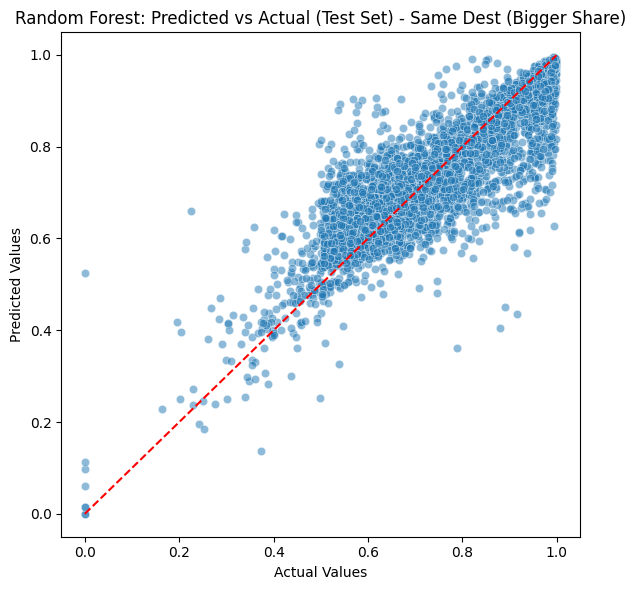

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_rf_2, X_train, X_test, y_train, y_test, y_pred, rf_imp_2 = run_random_forest_regression(
    df_regression=df_2_apts_same_destination_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Random Forest: Top Features by Importance - Same Dest (Bigger Share)",
    y_plot_title="Random Forest: Predicted vs Actual (Test Set) - Same Dest (Bigger Share)"
)


###Smaller share

SAME DESTINATION:

--- Evaluation on Test Set ---
RMSE: 0.0863
R² Score: 0.6659

--- Top 10 Features by Importance ---
             Feature  Importance
     origin_distance    0.087147
          fare_ratio    0.124070
       depcount_diff    0.328613
       capacity_diff    0.127044
    origin_size_diff    0.140473
international_market    0.011630
         month_April    0.005135
        month_August    0.006654
      month_December    0.002734
      month_February    0.004481


<ipython-input-82-2e4620dac813>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


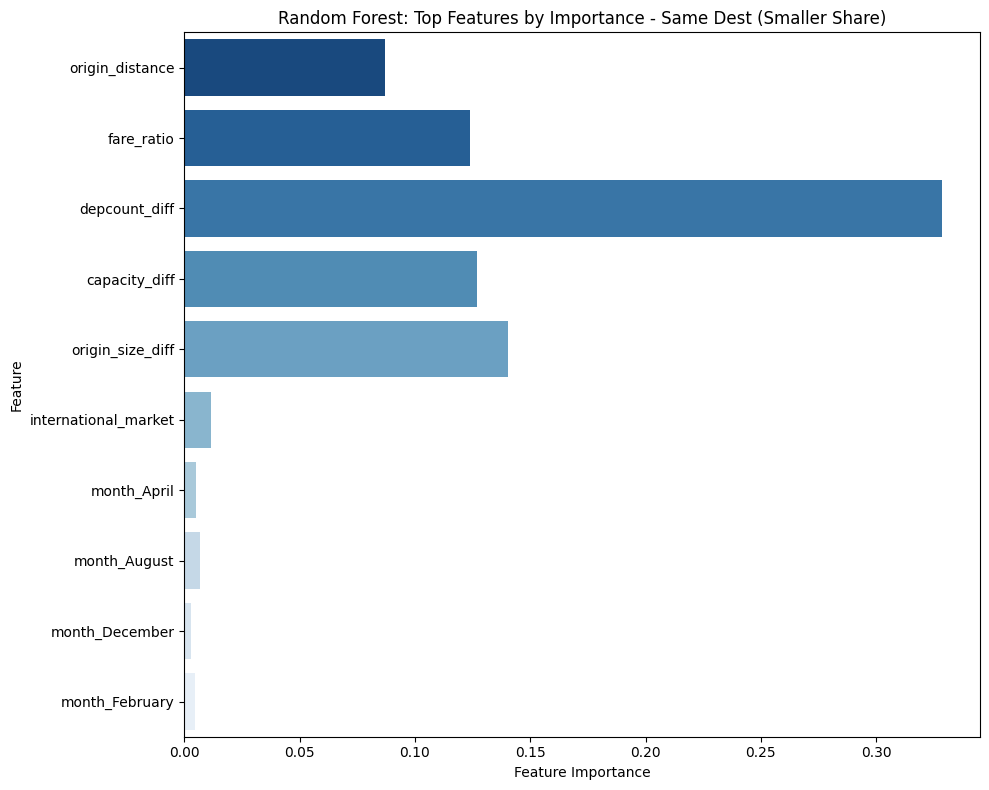

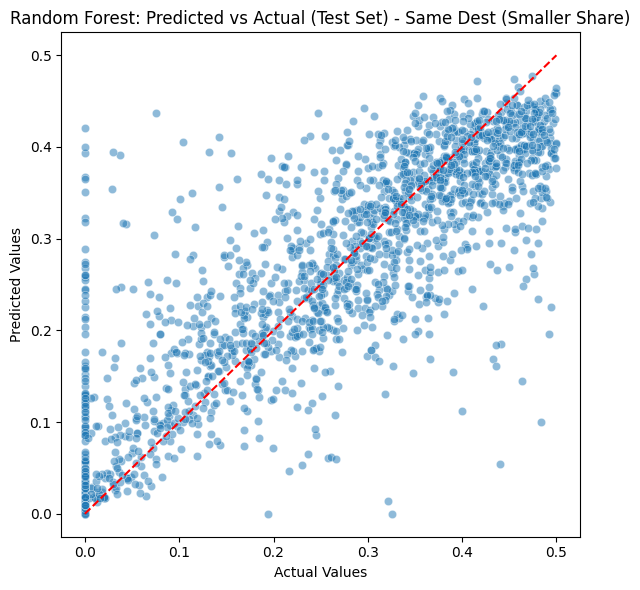

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_rf_3, X_train, X_test, y_train, y_test, y_pred, rf_imp_3 = run_random_forest_regression(
    df_regression=df_2_apts_same_destination_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Random Forest: Top Features by Importance - Same Dest (Smaller Share)",
    y_plot_title="Random Forest: Predicted vs Actual (Test Set) - Same Dest (Smaller Share)"
)


##Same Origin

SAME ORIGIN:

--- Evaluation on Test Set ---
RMSE: 0.1032
R² Score: 0.8459

--- Top 10 Features by Importance ---
              Feature  Importance
 destination_distance    0.064722
           fare_ratio    0.064400
        depcount_diff    0.082472
        capacity_diff    0.601662
destination_size_diff    0.074860
 international_market    0.009586
          month_April    0.002518
         month_August    0.002486
       month_December    0.002198
       month_February    0.002475


<ipython-input-82-2e4620dac813>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


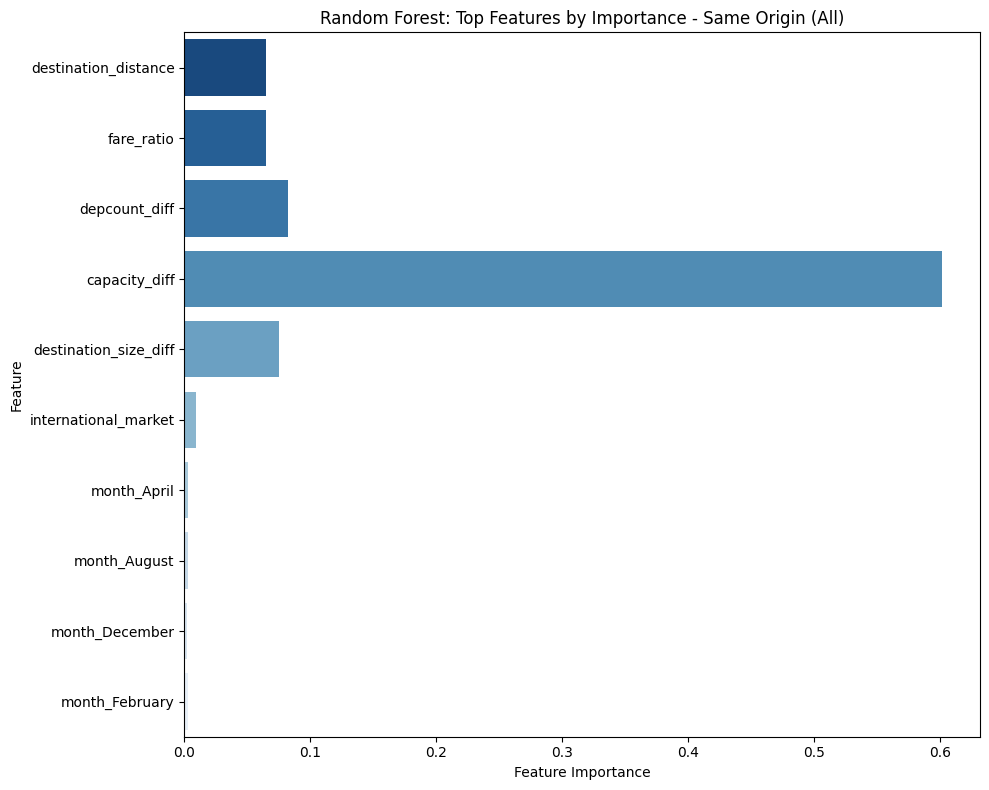

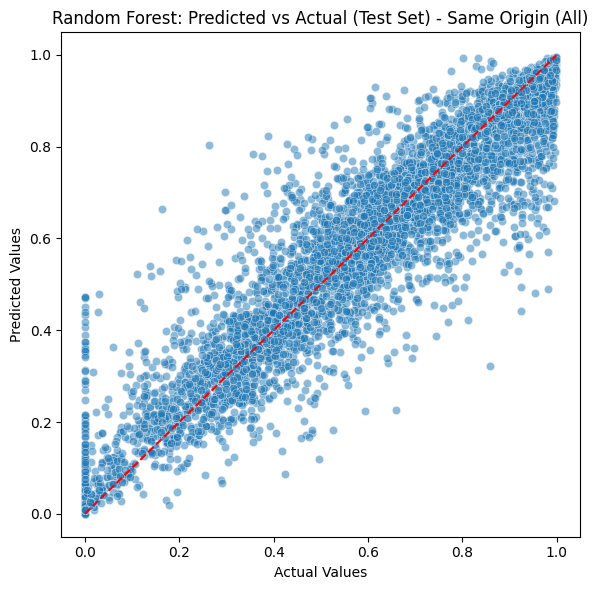

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_rf_4, X_train, X_test, y_train, y_test, y_pred, rf_imp_4 = run_random_forest_regression(
    df_regression=df_2_apts_same_origin_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Random Forest: Top Features by Importance - Same Origin (All)",
    y_plot_title = "Random Forest: Predicted vs Actual (Test Set) - Same Origin (All)"
)


###Bigger share

SAME ORIGIN:

--- Evaluation on Test Set ---
RMSE: 0.0826
R² Score: 0.7566

--- Top 10 Features by Importance ---
              Feature  Importance
 destination_distance    0.132303
           fare_ratio    0.113168
        depcount_diff    0.107998
        capacity_diff    0.336620
destination_size_diff    0.117844
 international_market    0.025869
          month_April    0.004352
         month_August    0.004144
       month_December    0.004347
       month_February    0.004871


<ipython-input-82-2e4620dac813>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


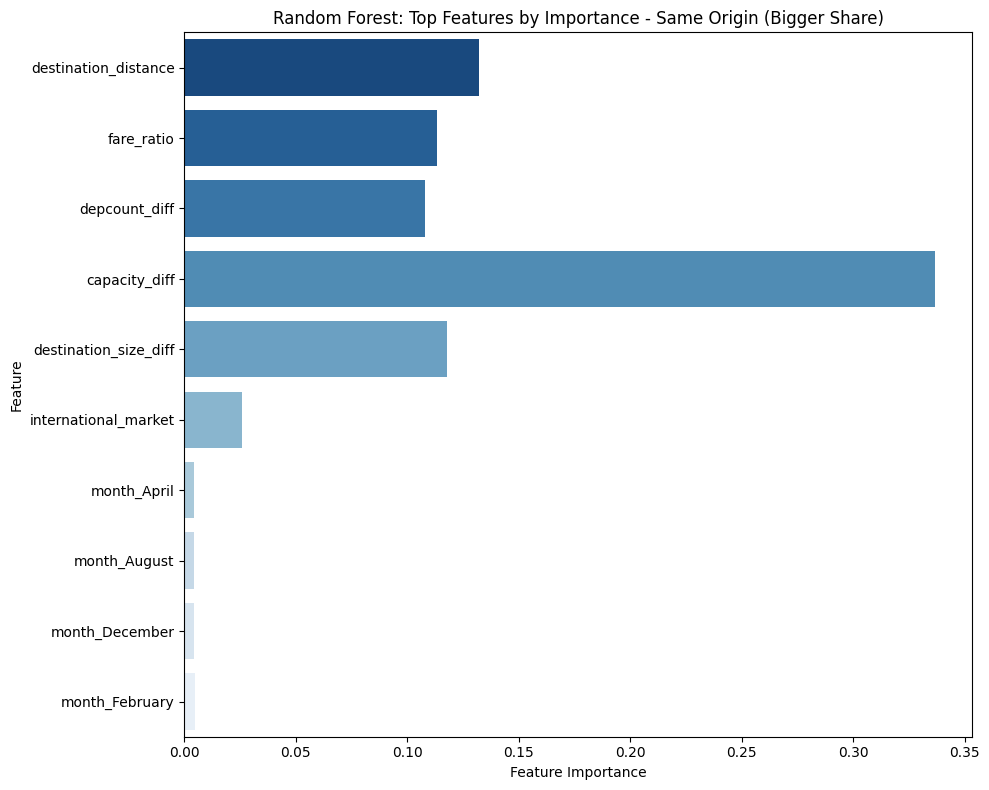

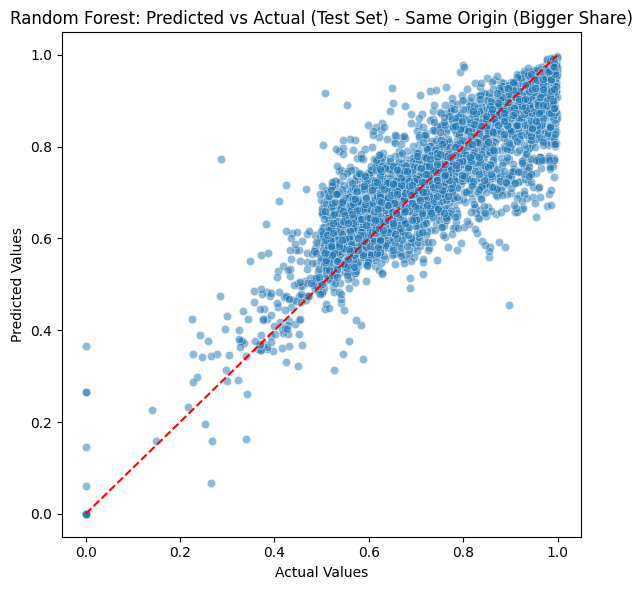

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_rf_5, X_train, X_test, y_train, y_test, y_pred, rf_imp_5 = run_random_forest_regression(
    df_regression=df_2_apts_same_origin_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Random Forest: Top Features by Importance - Same Origin (Bigger Share)",
    y_plot_title = "Random Forest: Predicted vs Actual (Test Set) - Same Origin (Bigger Share)"
)


###Smaller share

SAME ORIGIN:

--- Evaluation on Test Set ---
RMSE: 0.0874
R² Score: 0.6614

--- Top 10 Features by Importance ---
              Feature  Importance
 destination_distance    0.108062
           fare_ratio    0.135998
        depcount_diff    0.327675
        capacity_diff    0.144945
destination_size_diff    0.115381
 international_market    0.011163
          month_April    0.006137
         month_August    0.005826
       month_December    0.003978
       month_February    0.005431


<ipython-input-82-2e4620dac813>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


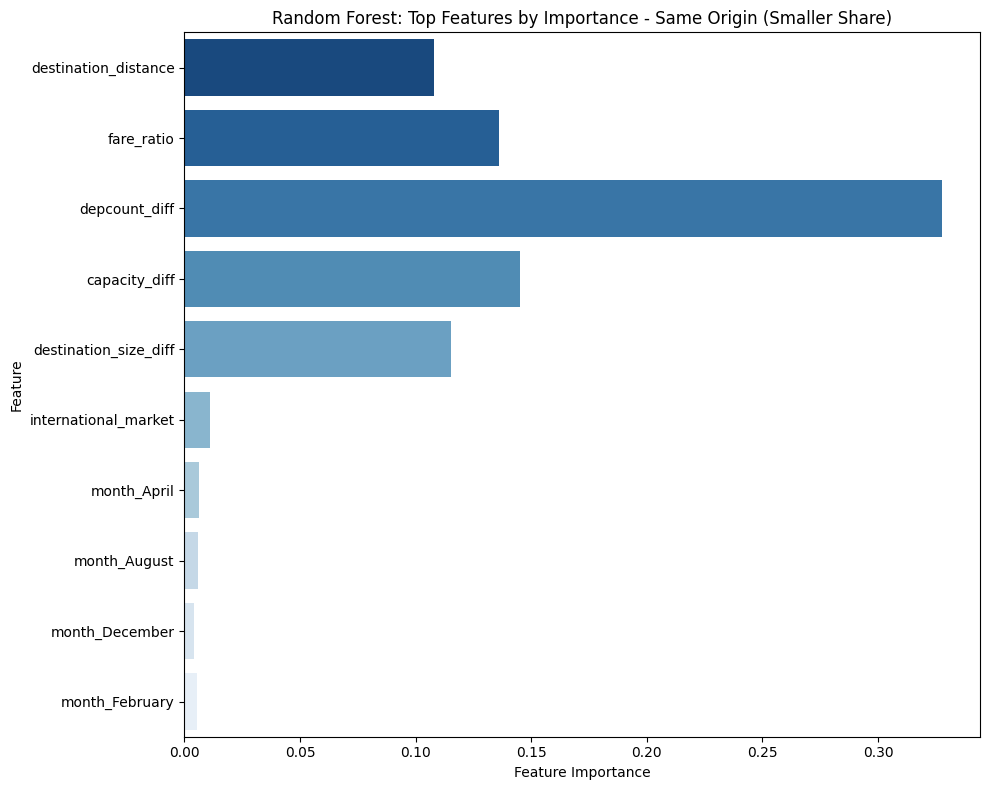

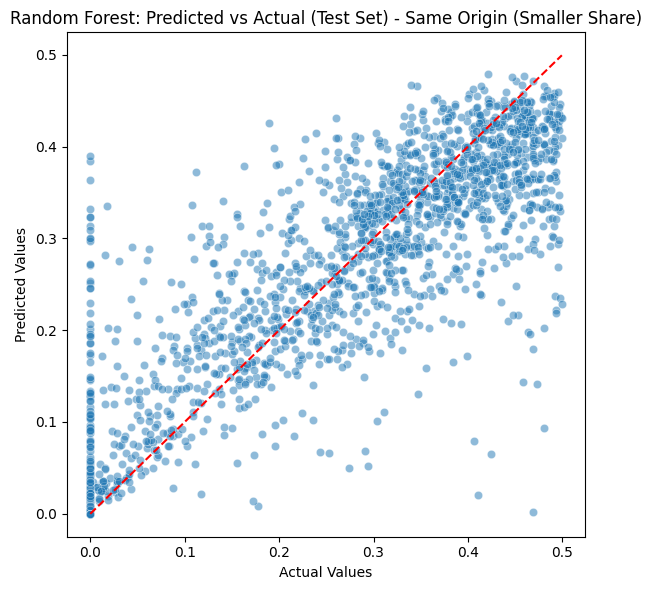

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_rf_6, X_train, X_test, y_train, y_test, y_pred, rf_imp_6 = run_random_forest_regression(
    df_regression=df_2_apts_same_origin_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Random Forest: Top Features by Importance - Same Origin (Smaller Share)",
    y_plot_title = "Random Forest: Predicted vs Actual (Test Set) - Same Origin (Smaller Share)"
)


###Summary RF

In [ ]:
df_rf_imp = []

df_rf_imp = pd.merge(rf_imp_1, rf_imp_2, on='Feature', how='outer', suffixes=('_1', '_2'))
df_rf_imp = pd.merge(df_rf_imp, rf_imp_3, on='Feature', how='outer', suffixes=('', '_3'))
df_rf_imp = pd.merge(df_rf_imp, rf_imp_4, on='Feature', how='outer', suffixes=('', '_4'))
df_rf_imp = pd.merge(df_rf_imp, rf_imp_5, on='Feature', how='outer', suffixes=('', '_5'))
df_rf_imp = pd.merge(df_rf_imp, rf_imp_6, on='Feature', how='outer', suffixes=('', '_6'))

df_rf_imp

Feature  Importance_1  Importance_2  \
0                        capacity_diff      0.587593      0.326076   
1                        depcount_diff      0.092102      0.115626   
2                 destination_distance           NaN           NaN   
3         destination_region_AUSTRALIA      0.000056      0.000050   
4         destination_region_CARIBBEAN      0.003991      0.006871   
5    destination_region_CENTRAL AFRICA      0.000022           NaN   
6   destination_region_CENTRAL AMERICA      0.001472      0.003627   
7      destination_region_CENTRAL ASIA      0.000795      0.001234   
8       destination_region_EAST AFRICA      0.000487      0.001402   
9    destination_region_EASTERN EUROPE      0.009247      0.011130   
10    destination_region_FAR EAST ASIA      0.001848      0.004790   
11             destination_region_GULF      0.001128      0.001317   
12      destination_region_MIDDLE EAST      0.003169      0.009644   
13     destination_region_NORTH AFRICA      0.001244      0.003036   
14    destination_region_NORTH AMERICA      0.007853      0.024698   
15          destination_region_PACIFIC      0.000045      0.000051   
16    destination_region_SOUTH AMERICA      0.002191      0.004497   
17   destination_region_SOUTHEAST ASIA      0.002199      0.005611   
18  destination_region_SOUTHERN AFRICA      0.000083      0.000038   
19      destination_region_WEST AFRICA      0.003080      0.000007   
20   destination_region_WESTERN EUROPE      0.009870      0.009926   
21               destination_size_diff           NaN           NaN   
22                          fare_ratio      0.065303      0.111443   
23                international_market      0.010319      0.021631   
24                         month_April      0.002498      0.003923   
25                        month_August      0.002458      0.004582   
26                      month_December      0.002144      0.005059   
27                      month_February      0.002225      0.004634   
28                          month_July      0.002652      0.004100   
29                          month_June      0.002483      0.003724   
30                         month_March      0.002769      0.004615   
31                           month_May      0.002462      0.004389   
32                      month_November      0.002308      0.003585   
33                       month_October      0.002738      0.004295   
34                     month_September      0.002531      0.004183   
35                     origin_distance      0.065287      0.129561   
36             origin_region_AUSTRALIA      0.000085      0.000036   
37             origin_region_CARIBBEAN      0.000465      0.000962   
38        origin_region_CENTRAL AFRICA      0.000082      0.000174   
39       origin_region_CENTRAL AMERICA      0.000067      0.000156   
40          origin_region_CENTRAL ASIA           NaN           NaN   
41           origin_region_EAST AFRICA      0.000275      0.000380   
42        origin_region_EASTERN EUROPE      0.010621      0.004917   
43         origin_region_FAR EAST ASIA      0.000811      0.001029   
44                  origin_region_GULF      0.000342      0.000836   
45           origin_region_MIDDLE EAST           NaN           NaN   
46          origin_region_NORTH AFRICA      0.000621      0.001950   
47         origin_region_NORTH AMERICA      0.003440      0.006169   
48               origin_region_PACIFIC      0.000053      0.000096   
49         origin_region_SOUTH AMERICA      0.001078      0.001758   
50        origin_region_SOUTHEAST ASIA      0.000459      0.001896   
51       origin_region_SOUTHERN AFRICA      0.000086      0.000081   
52        origin_region_WESTERN EUROPE      0.006158      0.006579   
53                    origin_size_diff      0.078707      0.133625   

      Importance  Importance_4  Importance_5  Importance_6  
0   1.270444e-01      0.601662      0.336620      0.144945  
1   3.286129e-01      0.082472      0.107998      0.327675

#XGBoost

##XGBoost Function

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_xgboost_regression(
    df_regression,
    target='1_percentage_Passengers',
    drop_columns=None,
    test_size=0.3,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    top_n_features=10,
    coef_plot_title="XGBoost: Top 50 Features by Importance",
    y_plot_title="XGBoost: Predicted vs Actual (Test Set)"
):
    df_model = df_regression.copy()
    if drop_columns:
        df_model = df_model.drop(columns=drop_columns, errors='ignore')

    X = df_model.drop(columns=[target])
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("\n--- Evaluation on Test Set ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importance summary
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": model.feature_importances_
    })#.sort_values(by="Importance", ascending=False)

    print(f"\n--- Top {top_n_features} Features by Importance ---")
    print(importance_df.head(top_n_features).to_string(index=False))

    # === Plot: Top N Importances ===
    top_importances = importance_df.head(top_n_features)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')
    plt.title(coef_plot_title)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # === Plot: Predicted vs Actual ===
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(y_plot_title)
    plt.tight_layout()
    plt.show()

    return model, X_train, X_test, y_train, y_test, y_pred, importance_df


##Same Destination

SAME DESTINATION:

--- Evaluation on Test Set ---
RMSE: 0.1450
R² Score: 0.7031

--- Top 10 Features by Importance ---
             Feature  Importance
     origin_distance    0.025167
          fare_ratio    0.016475
       depcount_diff    0.048832
       capacity_diff    0.477270
    origin_size_diff    0.027016
international_market    0.013570
         month_April    0.000000
        month_August    0.000000
      month_December    0.000286
      month_February    0.000269


<ipython-input-91-8ac79a218147>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


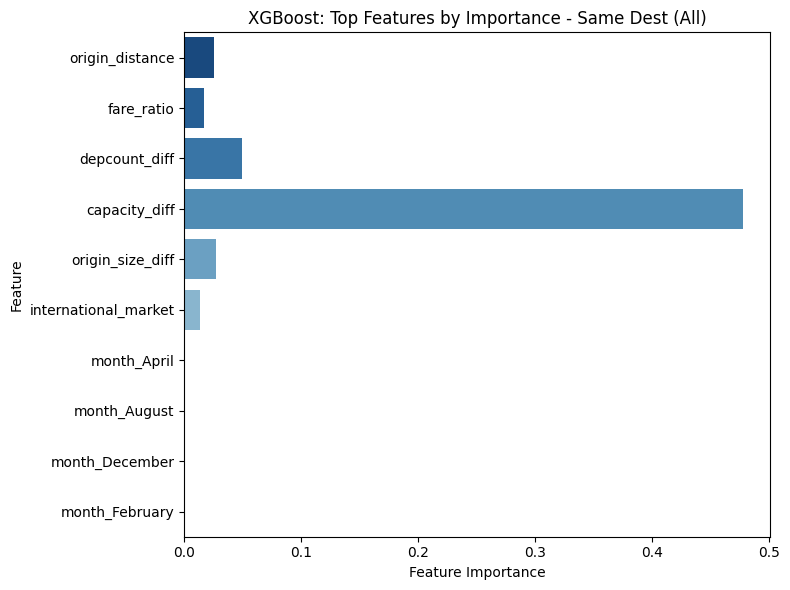

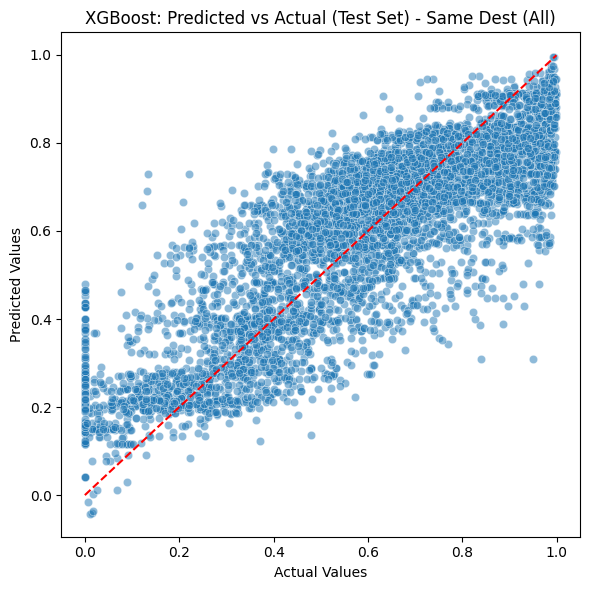

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_xgb_1, X_train, X_test, y_train, y_test, y_pred, xbg_imp_1 = run_xgboost_regression(
    df_regression=df_2_apts_same_destination_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="XGBoost: Top Features by Importance - Same Dest (All)",
    y_plot_title = "XGBoost: Predicted vs Actual (Test Set) - Same Dest (All)"
)


###Bigger share

SAME DESTINATION:

--- Evaluation on Test Set ---
RMSE: 0.1147
R² Score: 0.5135

--- Top 10 Features by Importance ---
             Feature  Importance
     origin_distance    0.059868
          fare_ratio    0.035668
       depcount_diff    0.051136
       capacity_diff    0.230067
    origin_size_diff    0.052439
international_market    0.030645
         month_April    0.000000
        month_August    0.000000
      month_December    0.000000
      month_February    0.000421


<ipython-input-91-8ac79a218147>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


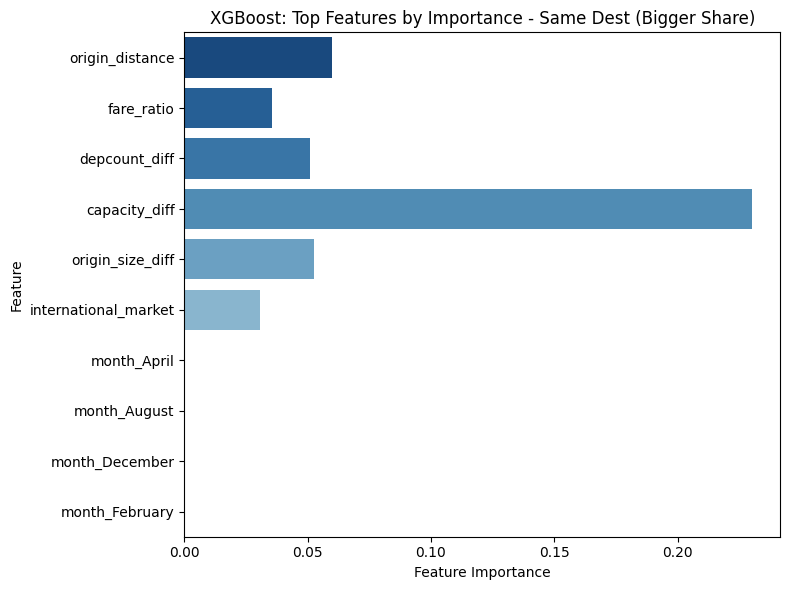

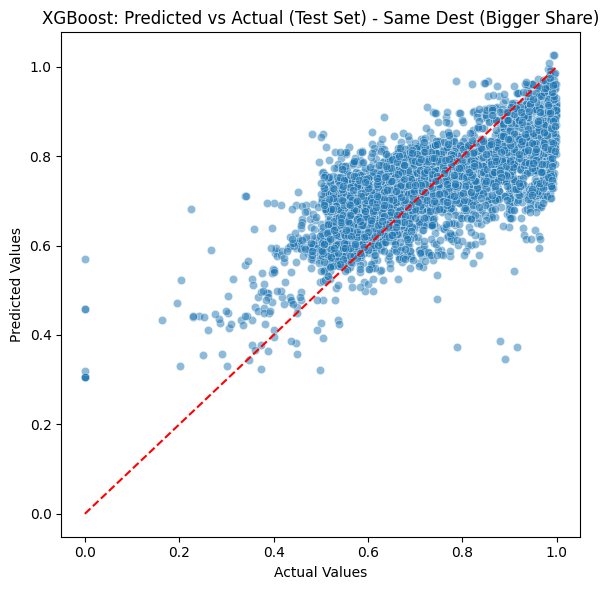

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_xgb_2, X_train, X_test, y_train, y_test, y_pred, xbg_imp_2 = run_xgboost_regression(
    df_regression=df_2_apts_same_destination_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="XGBoost: Top Features by Importance - Same Dest (Bigger Share)",
    y_plot_title="XGBoost: Predicted vs Actual (Test Set) - Same Dest (Bigger Share)"
)


###Smaller share

SAME DESTINATION:

--- Evaluation on Test Set ---
RMSE: 0.1015
R² Score: 0.5379

--- Top 10 Features by Importance ---
             Feature  Importance
     origin_distance    0.030009
          fare_ratio    0.020956
       depcount_diff    0.098882
       capacity_diff    0.085400
    origin_size_diff    0.052421
international_market    0.026590
         month_April    0.002319
        month_August    0.002262
      month_December    0.000000
      month_February    0.015271


<ipython-input-91-8ac79a218147>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


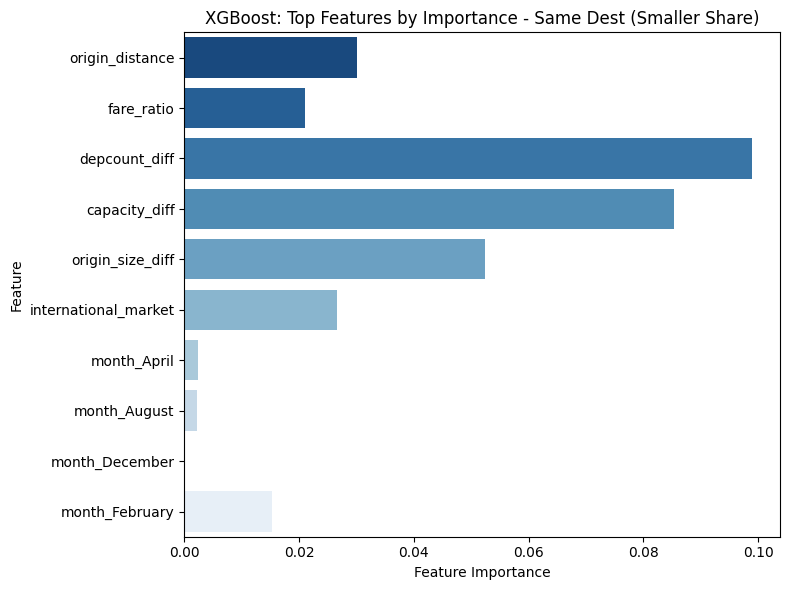

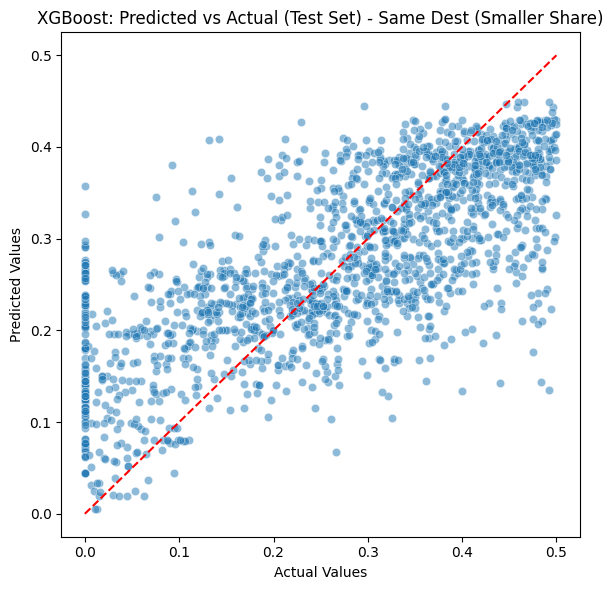

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    #'origin_distance',
    'destination_distance',
    #'origin_size_diff',
    'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME DESTINATION:')
model_xgb_3, X_train, X_test, y_train, y_test, y_pred, xbg_imp_3 = run_xgboost_regression(
    df_regression=df_2_apts_same_destination_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="XGBoost: Top Features by Importance - Same Dest (Smaller Share)",
    y_plot_title="XGBoost: Predicted vs Actual (Test Set) - Same Dest (Smaller Share)"
)


##Same Origin

SAME ORIGIN:

--- Evaluation on Test Set ---
RMSE: 0.1459
R² Score: 0.6920

--- Top 10 Features by Importance ---
              Feature  Importance
 destination_distance    0.025667
           fare_ratio    0.013334
        depcount_diff    0.035742
        capacity_diff    0.502174
destination_size_diff    0.027761
 international_market    0.014568
          month_April    0.006897
         month_August    0.000000
       month_December    0.000000
       month_February    0.000000


<ipython-input-91-8ac79a218147>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


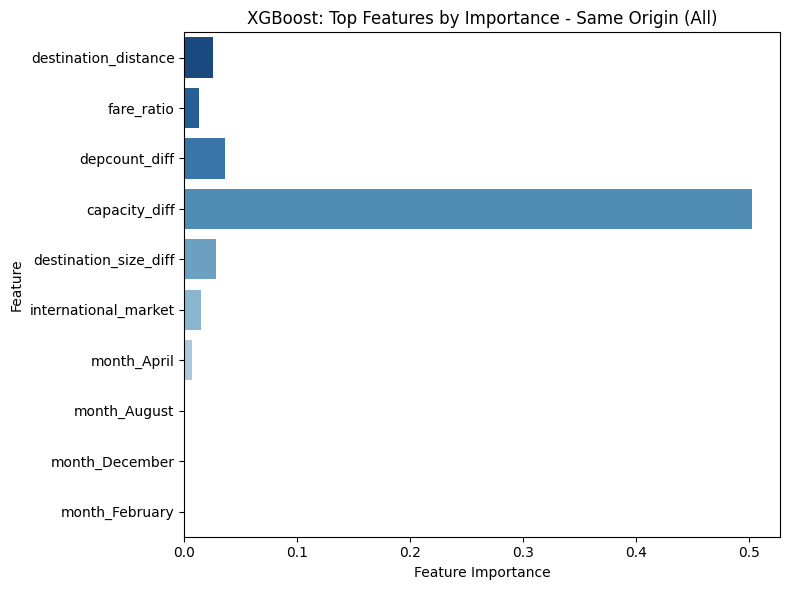

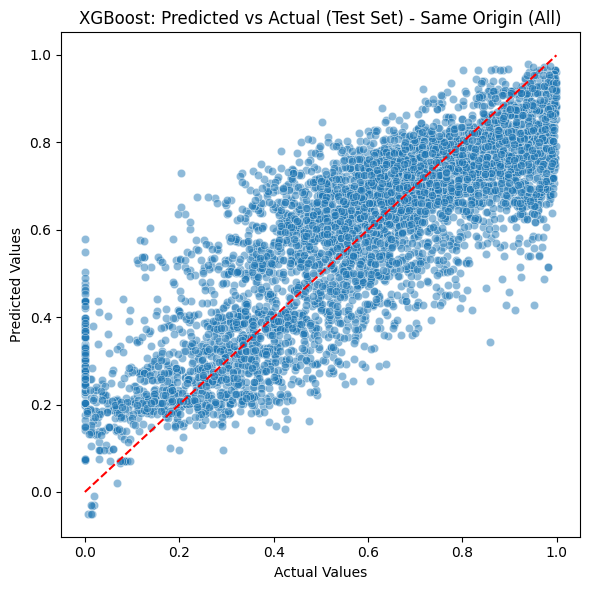

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_xgb_4, X_train, X_test, y_train, y_test, y_pred, xbg_imp_4 = run_xgboost_regression(
    df_regression=df_2_apts_same_origin_sorted_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="XGBoost: Top Features by Importance - Same Origin (All)",
    y_plot_title = "XGBoost: Predicted vs Actual (Test Set) - Same Origin (All)"
)


###Bigger share

SAME ORIGIN:

--- Evaluation on Test Set ---
RMSE: 0.1134
R² Score: 0.5412

--- Top 10 Features by Importance ---
              Feature  Importance
 destination_distance    0.055458
           fare_ratio    0.022055
        depcount_diff    0.040812
        capacity_diff    0.208438
destination_size_diff    0.048047
 international_market    0.030665
          month_April    0.000000
         month_August    0.000000
       month_December    0.000655
       month_February    0.000000


<ipython-input-91-8ac79a218147>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


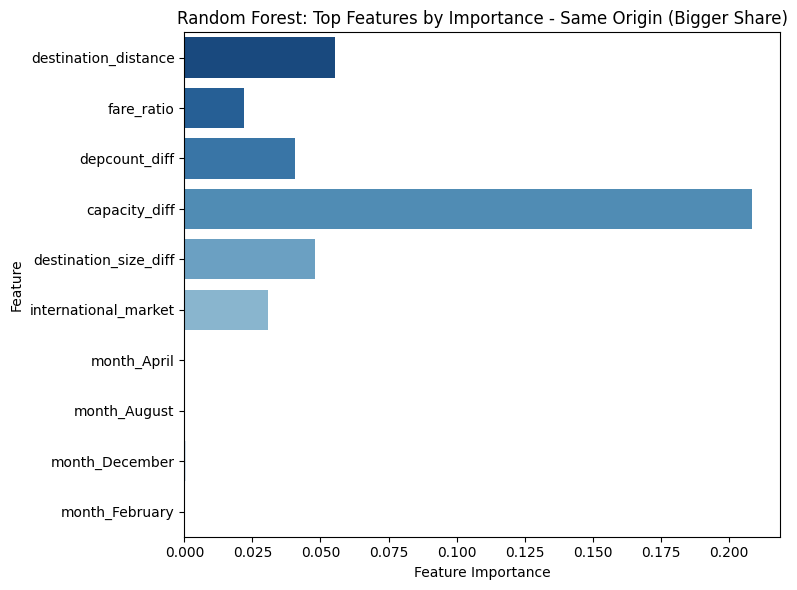

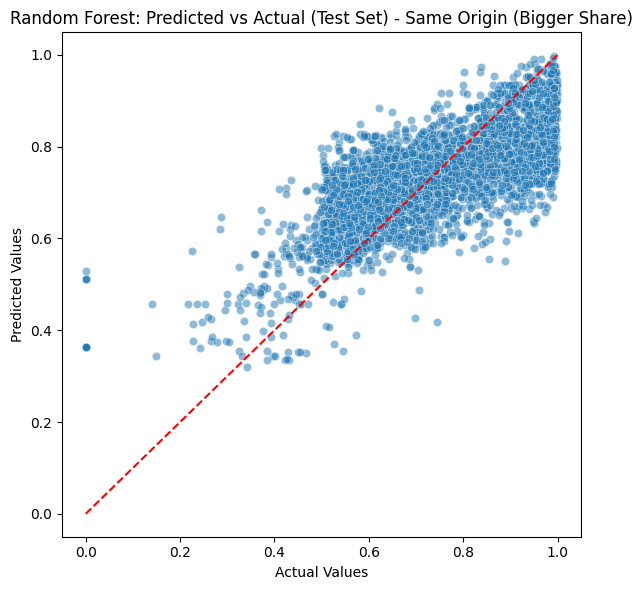

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_xgb_5, X_train, X_test, y_train, y_test, y_pred, xbg_imp_5 = run_xgboost_regression(
    df_regression=df_2_apts_same_origin_sorted_bigger_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="Random Forest: Top Features by Importance - Same Origin (Bigger Share)",
    y_plot_title = "Random Forest: Predicted vs Actual (Test Set) - Same Origin (Bigger Share)"
)


###Smaller share

SAME ORIGIN:

--- Evaluation on Test Set ---
RMSE: 0.1041
R² Score: 0.5205

--- Top 10 Features by Importance ---
              Feature  Importance
 destination_distance    0.036900
           fare_ratio    0.027537
        depcount_diff    0.179832
        capacity_diff    0.070312
destination_size_diff    0.053856
 international_market    0.046184
          month_April    0.007760
         month_August    0.010699
       month_December    0.000000
       month_February    0.002426


<ipython-input-91-8ac79a218147>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances['Importance'], y=top_importances['Feature'], palette='Blues_r')


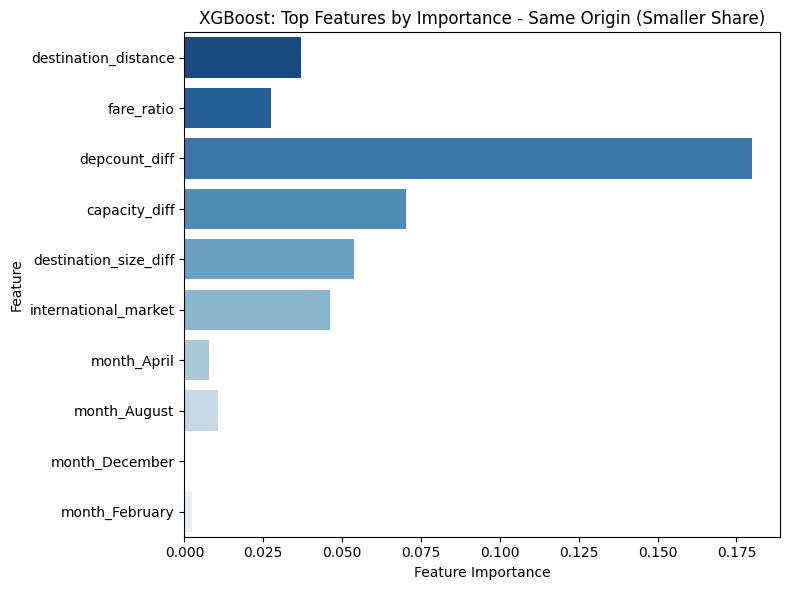

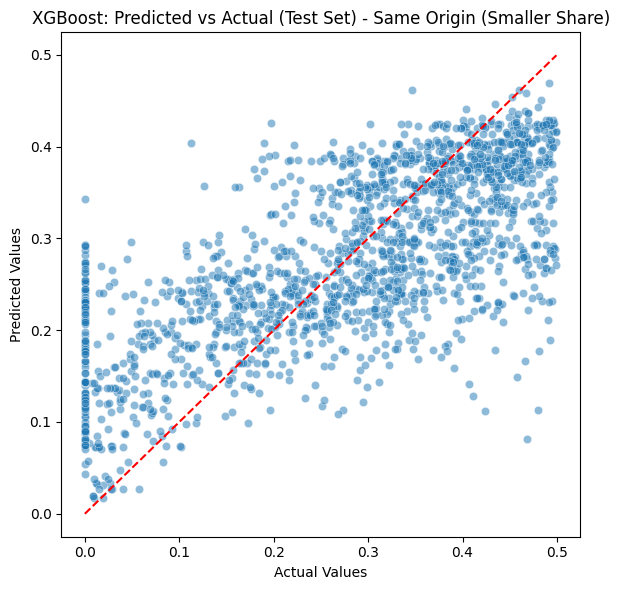

In [ ]:
drop_cols = [
    '1_percentage_PPDEW',
    'origin_distance',
    # 'destination_distance',
    'origin_size_diff',
    # 'destination_size_diff',
    'month_January',
    'origin_region_ASIA SUB-CONTINENT',
    'destination_region_ASIA SUB-CONTINENT'
]

print('SAME ORIGIN:')
model_xgb_6, X_train, X_test, y_train, y_test, y_pred, xbg_imp_6 = run_xgboost_regression(
    df_regression=df_2_apts_same_origin_sorted_smaller_share_regression,
    drop_columns=drop_cols,
    target='1_percentage_Passengers',
    coef_plot_title="XGBoost: Top Features by Importance - Same Origin (Smaller Share)",
    y_plot_title = "XGBoost: Predicted vs Actual (Test Set) - Same Origin (Smaller Share)"
)


In [ ]:
df_xgb_imp = []

df_xgb_imp = pd.merge(xbg_imp_1, xbg_imp_2, on='Feature', how='outer', suffixes=('_1', '_2'))
df_xgb_imp = pd.merge(df_xgb_imp, xbg_imp_3, on='Feature', how='outer', suffixes=('', '_3'))
df_xgb_imp = pd.merge(df_xgb_imp, xbg_imp_4, on='Feature', how='outer', suffixes=('', '_4'))
df_xgb_imp = pd.merge(df_xgb_imp, xbg_imp_5, on='Feature', how='outer', suffixes=('', '_5'))
df_xgb_imp = pd.merge(df_xgb_imp, xbg_imp_6, on='Feature', how='outer', suffixes=('', '_6'))

df_xgb_imp

Feature  Importance_1  Importance_2  \
0                        capacity_diff      0.477270      0.230067   
1                        depcount_diff      0.048832      0.051136   
2                 destination_distance           NaN           NaN   
3         destination_region_AUSTRALIA      0.000000      0.000000   
4         destination_region_CARIBBEAN      0.000000      0.000000   
5    destination_region_CENTRAL AFRICA      0.004368           NaN   
6   destination_region_CENTRAL AMERICA      0.005850      0.030666   
7      destination_region_CENTRAL ASIA      0.007247      0.007334   
8       destination_region_EAST AFRICA      0.009209      0.019531   
9    destination_region_EASTERN EUROPE      0.028084      0.067234   
10    destination_region_FAR EAST ASIA      0.024668      0.011328   
11             destination_region_GULF      0.000000      0.000000   
12      destination_region_MIDDLE EAST      0.030962      0.030112   
13     destination_region_NORTH AFRICA      0.000000      0.017527   
14    destination_region_NORTH AMERICA      0.049173      0.068397   
15          destination_region_PACIFIC      0.000000      0.000000   
16    destination_region_SOUTH AMERICA      0.022887      0.029940   
17   destination_region_SOUTHEAST ASIA      0.008442      0.019683   
18  destination_region_SOUTHERN AFRICA      0.000000      0.000000   
19      destination_region_WEST AFRICA      0.018861      0.000000   
20   destination_region_WESTERN EUROPE      0.021929      0.009228   
21               destination_size_diff           NaN           NaN   
22                          fare_ratio      0.016475      0.035668   
23                international_market      0.013570      0.030645   
24                         month_April      0.000000      0.000000   
25                        month_August      0.000000      0.000000   
26                      month_December      0.000286      0.000000   
27                      month_February      0.000269      0.000421   
28                          month_July      0.000000      0.000000   
29                          month_June      0.000000      0.002517   
30                         month_March      0.000000      0.000000   
31                           month_May      0.000000      0.000000   
32                      month_November      0.000012      0.000597   
33                       month_October      0.000000      0.000000   
34                     month_September      0.000847      0.000443   
35                     origin_distance      0.025167      0.059868   
36             origin_region_AUSTRALIA      0.000000      0.000000   
37             origin_region_CARIBBEAN      0.009574      0.008781   
38        origin_region_CENTRAL AFRICA      0.000000      0.008789   
39       origin_region_CENTRAL AMERICA      0.000000      0.000000   
40          origin_region_CENTRAL ASIA           NaN           NaN   
41           origin_region_EAST AFRICA      0.009697      0.038193   
42        origin_region_EASTERN EUROPE      0.050051      0.036169   
43         origin_region_FAR EAST ASIA      0.000000      0.000000   
44                  origin_region_GULF      0.000000      0.000000   
45           origin_region_MIDDLE EAST           NaN           NaN   
46          origin_region_NORTH AFRICA      0.000000      0.033874   
47         origin_region_NORTH AMERICA      0.017723      0.043971   
48               origin_region_PACIFIC      0.005678      0.000000   
49         origin_region_SOUTH AMERICA      0.034800      0.000000   
50        origin_region_SOUTHEAST ASIA      0.000000      0.015693   
51       origin_region_SOUTHERN AFRICA      0.000000      0.000000   
52        origin_region_WESTERN EUROPE      0.031052      0.039751   
53                    origin_size_diff      0.027016      0.052439   

    Importance  Importance_4  Importance_5  Importance_6  
0     0.085400      0.502174      0.208438      0.070312  
1     0.098882      0.035742      0.040812      0.179832  
2  